<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/home/cosenza/thesis/Polyphemus


In [2]:
!git branch

  main
* sparse


Libraries installation

In [20]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [21]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [22]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [3]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [4]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_PAD_IND = 2
MAX_DUR = 511 # equivalent to 16 bars (with RESOLUTION=32)

RESOLUTION = 32
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes) if notes else 0
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION) == 0 \
                            else length + (RESOLUTION-(length%(RESOLUTION)))


        tracks_tensors = []
        tracks_activations = []

        dur_bin_length = int(np.ceil(np.log2(MAX_DUR)))

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time

                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue

                track_tensor[t, notes_counter[t], 0] = note.pitch
                track_tensor[t, notes_counter[t], 1] = note.duration
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS

            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)

            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION+1, RESOLUTION):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION]

            if NUM_BARS > 1:
                # Skip sequence if it contains more than one bar of consecutive
                # silence in at least one track
                bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
                bars_acts = np.any(bars, axis=2)

                if 1 in np.diff(np.where(bars_acts == 0)[1]):
                    continue
            else:
                # In the case of just 1 bar, skip it if all tracks are silenced
                bar_acts = np.any(seq_acts, axis=1)
                if not np.any(bar_acts):
                    continue
                

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_EOS)
            seq_tensor[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples




# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, num_files=45129, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    not_filtered = 0
    finished = False
    
    print("Starting preprocessing")
    
    progress_bar = tqdm(range(early_exit)) if early_exit is not None else tqdm(range(num_files))
    start = time.time()

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)
        print()

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            n_saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += n_saved
            if n_saved > 0:
                not_filtered += 1
            
            progress_bar.update(1)
            
            # Todo: also print # of processed (not filtered) files
            #       and # of produced sequences (samples)
            print("Total number of seen files:", seen)
            print("Number of unique files:", len(files_dict))
            print("Total number of non filtered songs:", not_filtered)
            print("Total number of saved samples:", tot_samples)
            print()

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        if finished:
            break
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Preprocessing completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours),int(minutes),seconds))


In [5]:
!rm -rf data/preprocessed/
!mkdir data/preprocessed

In [6]:
dataset_dir = 'data/lmd_matched'
dest_dir = 'data/preprocessed'

Check preprocessed data:

In [7]:
preprocess_dataset(dataset_dir, dest_dir, early_exit=10)

Starting preprocessing


  0%|          | 0/10 [00:00<?, ?it/s]

Current path: data/lmd_matched

Current path: data/lmd_matched/A

Current path: data/lmd_matched/A/A

Current path: data/lmd_matched/A/A/A

Current path: data/lmd_matched/A/A/A/TRAAAGR128F425B14B

Preprocessing file data/lmd_matched/A/A/A/TRAAAGR128F425B14B/1d9d16a9da90c090809c153754823c2b.mid
Processing combination 1 of 7
Processing combination 2 of 7
Processing combination 3 of 7
Processing combination 4 of 7
Processing combination 5 of 7
Processing combination 6 of 7
Processing combination 7 of 7
File preprocessing finished. Saved samples: 3031

Total number of seen files: 1
Number of unique files: 1
Total number of non filtered songs: 1
Total number of saved samples: 3031

Preprocessing file data/lmd_matched/A/A/A/TRAAAGR128F425B14B/5dd29e99ed7bd3cc0c5177a6e9de22ea.mid
Processing combination 1 of 5
Processing combination 2 of 5
Processing combination 3 of 5
Processing combination 4 of 5
Processing combination 5 of 5
File preprocessing finished. Saved samples: 2105

Total number of 

/home/cosenza/anaconda3/envs/thesis/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Processing combination 1 of 2
Processing combination 2 of 2
File preprocessing finished. Saved samples: 1107

Total number of seen files: 3
Number of unique files: 3
Total number of non filtered songs: 3
Total number of saved samples: 6243

Preprocessing file data/lmd_matched/A/A/A/TRAAAGR128F425B14B/b97c529ab9ef783a849b896816001748.mid
Processing combination 1 of 4
Processing combination 2 of 4
Processing combination 3 of 4
Processing combination 4 of 4
File preprocessing finished. Saved samples: 1812

Total number of seen files: 4
Number of unique files: 4
Total number of non filtered songs: 4
Total number of saved samples: 8055

Current path: data/lmd_matched/A/A/A/TRAAAZF12903CCCF6B

Preprocessing file data/lmd_matched/A/A/A/TRAAAZF12903CCCF6B/c24989559d170135b9c6546d1d2df20b.mid
Processing combination 1 of 16
Processing combination 2 of 16
Processing combination 3 of 16
Processing combination 4 of 16
Processing combination 5 of 16
Processing combination 6 of 16
Processing combinat

In [8]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [9]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [10]:
data["seq_tensor"][0, 0]

array([[128,   0],
       [129,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0]], dtype=int16)

# Model

In [11]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot[np.arange(0, onehot.shape[0]), pitches.reshape(-1)] = 1.
        onehot = onehot.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to binary (pitch)
        durs = seq_tensor[:, :, :, 1]
        bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]

        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot[:, :, :, :], bin_durs),
                             axis=-1)
        
        # Construct graph from boolean activations
        # Todo: optimize and refactor
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        
        #n = seq_acts.shape[0]*seq_acts.shape[1]
        n = torch.sum(torch.Tensor(seq_acts), dtype=torch.long) # sparse
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [12]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
        self.p = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=140, d_transf=256, nhead_transf=4, 
                 num_layers_transf=2, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        encoding = scatter_mean(x_graph.x, x_graph.batch, dim=0)
        #num_nodes = x_graph[0].num_nodes
        #batch_sz = node_encs.size(0) // num_nodes
        #node_encs = node_encs.view(batch_sz, num_nodes, -1)
        #encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=140, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=2, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, 140)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        _, counts = torch.unique(x_graph.batch, return_counts=True)
        node_features = torch.repeat_interleave(z, counts, axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]
        #print(src_mask.size())
        #print(x_seq.size())
        
        embs = self.embedding(x_seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var


Trainer

In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy
import time
from statistics import mean
from collections import defaultdict


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


class VAETrainer():
    
    def __init__(self, model, models_path, optimizer, init_lr,
                 name=None, lr_scheduler=None, device=torch.device("cuda"), 
                 print_every=1, save_every=1):
        
        self.model = model
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.name = name if name is not None else str(uuid.uuid4())
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
        self.model_path = os.path.join(self.models_path, self.name)
        
        # Criterions with ignored padding
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce = nn.CrossEntropyLoss(ignore_index=130) #
        
        # Training stats
        self.losses = defaultdict(list)
        self.accuracies = defaultdict(list)
        self.lrs = []
        self.times = []
        
    
    def train(self, trainloader, validloader=None, epochs=1,
              early_exit=None):
        
        n_batches = len(trainloader)

        beta = 0 # Todo: _update_params()
        
        self.model.train()
        
        print("Starting training.\n")
        
        start = time.time()
        self.times.append(start)
        
        tot_batches = 0
        
        for epoch in range(epochs):
            
            self.cur_epoch = epoch
            progress_bar = tqdm(range(n_batches))
            
            for batch_idx, inputs in enumerate(trainloader):
                
                self.cur_batch_idx = batch_idx
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq, x_acts, x_graph, src_mask = inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)
                src_mask = src_mask.to(self.device)
                tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(self.device)
                inputs = (x_seq, x_acts, x_graph)

                # Forward pass, get the reconstructions
                outputs, mu, log_var = self.model(x_seq, x_acts, x_graph, src_mask, tgt_mask)
                
                # Compute the backprop loss and other required losses
                tot_loss, losses = self._compute_losses(inputs, outputs, mu,
                                                         log_var, beta)
                
                # Backprop and update lr
                tot_loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                    
                # Update the stats
                self._append_losses(losses)
                
                last_lr = (self.lr_scheduler.get_last_lr()[0] 
                               if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                
                accs = self._compute_accuracies(inputs, outputs)
                self._append_accuracies(accs)
                
                now = time.time()
                self.times.append(now)
                
                # Print stats
                if (tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1, n_batches, epoch+1, epochs))
                    self._print_stats()
                    #print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          #.format(running_loss/self.print_every, acts_loss), end='')
                    #print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          #.format(pitches_loss, dur_loss, kld_loss))
                    print("\n----------------------------------------\n")
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (tot_batches + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    self._save_model()
                
                progress_bar.update(1)
                
                # Stop prematurely if early_exit is set and reached
                if early_exit is not None and (tot_batches + 1) > early_exit:
                    break
                
                tot_batches += 1
            

        end = time.time()
        # Todo: self.__print_time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        self._save_model()
        
        print("Model saved.")
        
    
    def _compute_losses(self, inputs, outputs, mu, log_var, beta):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        mask = (pitches_true != 130).unsqueeze(-1)
                
        # Compute the losses
        acts_loss = self.bce(acts_rec.view(-1), x_acts.view(-1).float())
        pitches_loss = self.ce(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                          x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
        dur_loss = self.bce_unreduced(seq_rec[..., 131:], 
                       x_seq[..., 131:])
        dur_loss = mask * dur_loss
        dur_loss = torch.sum(dur_loss) / torch.sum(mask)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_loss = pitches_loss + dur_loss + acts_loss
        tot_loss = rec_loss + beta*kld_loss
        
        losses = {
            'tot': tot_loss.item(),
            'pitches': pitches_loss.item(),
            'dur': dur_loss.item(),
            'acts': acts_loss.item(),
            'rec': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': beta*kld_loss.item()
        }
        
        return tot_loss, losses

    
    def _append_losses(self, losses):
        
        for k, loss in losses.items():
            self.losses[k].append(loss)
            
            
    def _compute_accuracies(self, inputs, outputs):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        notes_acc = self._note_accuracy(seq_rec, x_seq)
        pitches_acc = self._pitches_accuracy(seq_rec, x_seq)
        dur_acc = self._dur_accuracy(seq_rec, x_seq)
        acts_acc = self._acts_accuracy(acts_rec, x_acts)
        
        accs = {
            'notes': notes_acc.item(),
            'pitches': pitches_acc.item(),
            'dur': dur_acc.item(),
            'acts': acts_acc.item()
        }
        
        return accs
        
        
    def _append_accuracies(self, accs):
        
        for k, acc in accs.items():
            self.accuracies[k].append(acc)
    
    
    def _note_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        #print(torch.all(pitches_rec == 130))
        #print(pitches_rec)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        #print(torch.all(dur_rec == 0))
        #print(dur_rec)
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(torch.logical_and(preds_pitches, 
                                           preds_dur)) / torch.sum(mask)
    
    
    def _acts_accuracy(self, acts_rec, x_acts):
        
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        
        #print(torch.all(acts_rec == 0))
        #print(acts_rec)
        
        return torch.sum(acts_rec == x_acts) / x_acts.numel()
    
    
    def _pitches_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        return torch.sum(preds_pitches) / torch.sum(mask)
    
    
    def _dur_accuracy(self, seq_rec, x_seq):
        
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(preds_dur) / torch.sum(mask)
    
    
    def _save_model(self):
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'save_every': self.save_every,
            'lrs': self.lrs,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, self.model_path)
        
        
    def _print_stats(self):
        
        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours), int(minutes), seconds))
        
        avg_lr = mean(self.lrs[-self.print_every:])
        
        # Take mean of the last non-printed batches for each stat
        
        avg_losses = {}
        for k, l in self.losses.items():
            avg_losses[k] = mean(l[-self.print_every:])
        
        avg_accs = {}
        for k, l in self.accuracies.items():
            avg_accs[k] = mean(l[-self.print_every:])
        
        print("Losses:")
        print(avg_losses)
        print("Accuracies:")
        print(avg_accs)
        


Training

In [14]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [15]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)

31001

In [16]:
import torch
torch.cuda.set_device(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#decive = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 0


In [17]:
!rm models/vae

In [18]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [35]:
print("Creating the model and moving it to the specified device...")

vae = VAE(dropout=0).to(device)
print_params(vae)
print()

init_lr = 5e-6
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(
    vae,
    models_path,
    optimizer,
    init_lr,
    name='vae2',
    lr_scheduler=scheduler,
    save_every=100, 
    device=device
)
trainer.train(loader, epochs=100)

Creating the model and moving it to the specified device...
+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                    encoder.embedding.weight                    |   35840    |
|                     encoder.embedding.bias                     |    256     |
| encoder.transformer_encoder.layers.0.self_attn.in_proj_weight  |   196608   |
|  encoder.transformer_encoder.layers.0.self_attn.in_proj_bias   |    768     |
| encoder.transformer_encoder.layers.0.self_attn.out_proj.weight |   65536    |
|  encoder.transformer_encoder.layers.0.self_attn.out_proj.bias  |    256     |
|      encoder.transformer_encoder.layers.0.linear1.weight       |   524288   |
|       encoder.transformer_encoder.layers.0.linear1.bias        |    2048    |
|      encoder.transformer_encoder.layers.0.linear2.weight  

  0%|          | 0/969 [00:00<?, ?it/s]

Training on batch 1/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.25
Losses:
{'tot': 13.066625595092773, 'pitches': 5.1358256340026855, 'dur': 7.182944297790527, 'acts': 0.747856080532074, 'rec': 13.066625595092773, 'kld': 1635.99462890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.006833713036030531, 'dur': 0.0, 'acts': 0.500732421875}

----------------------------------------

Training on batch 2/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.40
Losses:
{'tot': 13.08290958404541, 'pitches': 5.2755446434021, 'dur': 7.055608749389648, 'acts': 0.7517558336257935, 'rec': 13.08290958404541, 'kld': 1639.186767578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0023041474632918835, 'dur': 0.0, 'acts': 0.501708984375}

----------------------------------------

Training on batch 3/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.54
Losses:
{'tot': 12.854578971862793, 'pitches': 5.126912117004394

Training on batch 21/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:03.02
Losses:
{'tot': 11.305314064025879, 'pitches': 5.020983695983887, 'dur': 5.5376362800598145, 'acts': 0.7466938495635986, 'rec': 11.305314064025879, 'kld': 1644.6800537109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0021459227427840233, 'dur': 0.019313305616378784, 'acts': 0.495849609375}

----------------------------------------

Training on batch 22/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:03.16
Losses:
{'tot': 11.210579872131348, 'pitches': 5.015575408935547, 'dur': 5.451107501983643, 'acts': 0.7438977956771851, 'rec': 11.210579872131348, 'kld': 1643.7998046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0017123287543654442, 'dur': 0.0051369862630963326, 'acts': 0.50439453125}

----------------------------------------

Training on batch 23/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:03.29
Losses:
{'tot': 11.05

Training on batch 41/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.71
Losses:
{'tot': 10.011011123657227, 'pitches': 4.830198764801025, 'dur': 4.443556308746338, 'acts': 0.7372558116912842, 'rec': 10.011011123657227, 'kld': 1710.66650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0038910505827516317, 'pitches': 0.011673151515424252, 'dur': 0.1750972718000412, 'acts': 0.517822265625}

----------------------------------------

Training on batch 42/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.83
Losses:
{'tot': 9.890739440917969, 'pitches': 4.842001438140869, 'dur': 4.333369255065918, 'acts': 0.7153686285018921, 'rec': 9.890739440917969, 'kld': 1712.7884521484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0021321962121874094, 'dur': 0.15778250992298126, 'acts': 0.528076171875}

----------------------------------------

Training on batch 43/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.97
Losses:
{

Training on batch 61/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:08.36
Losses:
{'tot': 9.084036827087402, 'pitches': 4.608903408050537, 'dur': 3.764848232269287, 'acts': 0.7102847695350647, 'rec': 9.084036827087402, 'kld': 1796.83740234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.00749063678085804, 'pitches': 0.03558052331209183, 'dur': 0.23970037698745728, 'acts': 0.53759765625}

----------------------------------------

Training on batch 62/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:08.49
Losses:
{'tot': 9.144827842712402, 'pitches': 4.613265514373779, 'dur': 3.8138418197631836, 'acts': 0.7177211046218872, 'rec': 9.144827842712402, 'kld': 1803.16455078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.027713626623153687, 'pitches': 0.03695150092244148, 'dur': 0.2909930646419525, 'acts': 0.53271484375}

----------------------------------------

Training on batch 63/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:08.62
Lo

Training on batch 81/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:11.01
Losses:
{'tot': 8.557046890258789, 'pitches': 4.410466194152832, 'dur': 3.455186367034912, 'acts': 0.6913944482803345, 'rec': 8.557046890258789, 'kld': 1890.9501953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.13308687508106232, 'pitches': 0.3123844861984253, 'dur': 0.35859519243240356, 'acts': 0.5703125}

----------------------------------------

Training on batch 82/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:11.13
Losses:
{'tot': 8.458597183227539, 'pitches': 4.356077194213867, 'dur': 3.4072976112365723, 'acts': 0.695222795009613, 'rec': 8.458597183227539, 'kld': 1897.9617919921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.14437367022037506, 'pitches': 0.3227176368236542, 'dur': 0.36093416810035706, 'acts': 0.562255859375}

----------------------------------------

Training on batch 83/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:11.26
Losses:

Training on batch 100/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:13.65
Losses:
{'tot': 8.195816993713379, 'pitches': 4.208622932434082, 'dur': 3.30230450630188, 'acts': 0.6848899126052856, 'rec': 8.195816993713379, 'kld': 1989.393798828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.16283924877643585, 'pitches': 0.3298538625240326, 'dur': 0.34237995743751526, 'acts': 0.578125}

----------------------------------------


Saving model to disk...

Training on batch 101/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:14.01
Losses:
{'tot': 8.123530387878418, 'pitches': 4.170200824737549, 'dur': 3.2719199657440186, 'acts': 0.6814095973968506, 'rec': 8.123530387878418, 'kld': 1994.60400390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.13600000739097595, 'pitches': 0.3400000035762787, 'dur': 0.28200000524520874, 'acts': 0.574951171875}

----------------------------------------

Training on batch 102/969 of epoch 1/100 complete.
Elapsed time from start 

Training on batch 119/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:16.34
Losses:
{'tot': 7.7414374351501465, 'pitches': 3.9916558265686035, 'dur': 3.0833849906921387, 'acts': 0.6663967370986938, 'rec': 7.7414374351501465, 'kld': 2086.668701171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.1757049858570099, 'pitches': 0.33622559905052185, 'dur': 0.4034707248210907, 'acts': 0.60498046875}

----------------------------------------

Training on batch 120/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:16.47
Losses:
{'tot': 7.738773822784424, 'pitches': 4.011544227600098, 'dur': 3.0637636184692383, 'acts': 0.6634658575057983, 'rec': 7.738773822784424, 'kld': 2090.510498046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.1588594764471054, 'pitches': 0.34419551491737366, 'dur': 0.3584521412849426, 'acts': 0.60302734375}

----------------------------------------

Training on batch 121/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:16.

Training on batch 139/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:18.94
Losses:
{'tot': 7.527036190032959, 'pitches': 3.852268695831299, 'dur': 3.027289390563965, 'acts': 0.6474781036376953, 'rec': 7.527036190032959, 'kld': 2188.171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.19495412707328796, 'pitches': 0.33944955468177795, 'dur': 0.3600917458534241, 'acts': 0.61767578125}

----------------------------------------

Training on batch 140/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:19.06
Losses:
{'tot': 7.54418420791626, 'pitches': 3.9219772815704346, 'dur': 2.9752559661865234, 'acts': 0.6469512581825256, 'rec': 7.54418420791626, 'kld': 2191.39501953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.1875, 'pitches': 0.3216911852359772, 'dur': 0.40808823704719543, 'acts': 0.619140625}

----------------------------------------

Training on batch 141/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:19.20
Losses:
{'tot': 7.4244

Training on batch 159/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:21.53
Losses:
{'tot': 7.415932655334473, 'pitches': 3.8816983699798584, 'dur': 2.900233268737793, 'acts': 0.6340005397796631, 'rec': 7.415932655334473, 'kld': 2279.08203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.21010100841522217, 'pitches': 0.3232323229312897, 'dur': 0.39191919565200806, 'acts': 0.63671875}

----------------------------------------

Training on batch 160/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:21.67
Losses:
{'tot': 7.502745628356934, 'pitches': 3.8665969371795654, 'dur': 2.996739149093628, 'acts': 0.6394097805023193, 'rec': 7.502745628356934, 'kld': 2284.66162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2233201563358307, 'pitches': 0.3241106867790222, 'dur': 0.3853754997253418, 'acts': 0.635009765625}

----------------------------------------

Training on batch 161/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:21.81
Losses:

Training on batch 179/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:24.32
Losses:
{'tot': 7.257073879241943, 'pitches': 3.8208556175231934, 'dur': 2.821200370788574, 'acts': 0.6150180101394653, 'rec': 7.257073879241943, 'kld': 2365.4794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.23664122819900513, 'pitches': 0.3263358771800995, 'dur': 0.4198473393917084, 'acts': 0.662841796875}

----------------------------------------

Training on batch 180/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:24.45
Losses:
{'tot': 7.200066566467285, 'pitches': 3.7074244022369385, 'dur': 2.8777832984924316, 'acts': 0.6148584485054016, 'rec': 7.200066566467285, 'kld': 2374.41748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.22371365129947662, 'pitches': 0.3467561602592468, 'dur': 0.40044742822647095, 'acts': 0.666259765625}

----------------------------------------

Training on batch 181/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:24.58

Training on batch 199/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:27.09
Losses:
{'tot': 7.054451942443848, 'pitches': 3.682331085205078, 'dur': 2.7521164417266846, 'acts': 0.6200045347213745, 'rec': 7.054451942443848, 'kld': 2449.240234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.23175182938575745, 'pitches': 0.34306567907333374, 'dur': 0.4197080433368683, 'acts': 0.66552734375}

----------------------------------------

Training on batch 200/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:27.23
Losses:
{'tot': 7.0257954597473145, 'pitches': 3.670224905014038, 'dur': 2.7477431297302246, 'acts': 0.6078277826309204, 'rec': 7.0257954597473145, 'kld': 2454.530029296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.22595077753067017, 'pitches': 0.3467561602592468, 'dur': 0.38926175236701965, 'acts': 0.67041015625}

----------------------------------------


Saving model to disk...

Training on batch 201/969 of epoch 1/100 complete.
Elapsed time from 

Training on batch 219/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:30.52
Losses:
{'tot': 7.073988914489746, 'pitches': 3.7497920989990234, 'dur': 2.722879648208618, 'acts': 0.601317286491394, 'rec': 7.073988914489746, 'kld': 2529.16943359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.22520661354064941, 'pitches': 0.32438015937805176, 'dur': 0.3822314143180847, 'acts': 0.674072265625}

----------------------------------------

Training on batch 220/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:30.68
Losses:
{'tot': 7.111228942871094, 'pitches': 3.7739274501800537, 'dur': 2.7453651428222656, 'acts': 0.5919363498687744, 'rec': 7.111228942871094, 'kld': 2531.730712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.21301774680614471, 'pitches': 0.3214990198612213, 'dur': 0.3865877687931061, 'acts': 0.6923828125}

----------------------------------------

Training on batch 221/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:30.83


Training on batch 239/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:33.30
Losses:
{'tot': 6.898829460144043, 'pitches': 3.6829795837402344, 'dur': 2.635270357131958, 'acts': 0.5805798172950745, 'rec': 6.898829460144043, 'kld': 2609.01123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.24531835317611694, 'pitches': 0.33707866072654724, 'dur': 0.4101123511791229, 'acts': 0.71337890625}

----------------------------------------

Training on batch 240/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:33.43
Losses:
{'tot': 6.986788749694824, 'pitches': 3.6677587032318115, 'dur': 2.739075183868408, 'acts': 0.5799553394317627, 'rec': 6.986788749694824, 'kld': 2614.12060546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2545454502105713, 'pitches': 0.33454546332359314, 'dur': 0.39818182587623596, 'acts': 0.700927734375}

----------------------------------------

Training on batch 241/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:33.56

Training on batch 259/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:35.95
Losses:
{'tot': 6.84344482421875, 'pitches': 3.664943218231201, 'dur': 2.607123851776123, 'acts': 0.5713775753974915, 'rec': 6.84344482421875, 'kld': 2692.51513671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2469387799501419, 'pitches': 0.3163265287876129, 'dur': 0.4183673560619354, 'acts': 0.71826171875}

----------------------------------------

Training on batch 260/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:36.08
Losses:
{'tot': 7.025912284851074, 'pitches': 3.659991979598999, 'dur': 2.803701877593994, 'acts': 0.5622188448905945, 'rec': 7.025912284851074, 'kld': 2698.38525390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27226462960243225, 'pitches': 0.32824426889419556, 'dur': 0.3994911015033722, 'acts': 0.729736328125}

----------------------------------------

Training on batch 261/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:36.21
Losse

Training on batch 279/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:38.57
Losses:
{'tot': 6.981657028198242, 'pitches': 3.764329195022583, 'dur': 2.6632938385009766, 'acts': 0.5540344715118408, 'rec': 6.981657028198242, 'kld': 2766.89599609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2618025839328766, 'pitches': 0.29828324913978577, 'dur': 0.3884120285511017, 'acts': 0.745361328125}

----------------------------------------

Training on batch 280/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:38.70
Losses:
{'tot': 6.898522853851318, 'pitches': 3.6662464141845703, 'dur': 2.673560619354248, 'acts': 0.5587158203125, 'rec': 6.898522853851318, 'kld': 2773.299072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2790178656578064, 'pitches': 0.3214285671710968, 'dur': 0.4397321343421936, 'acts': 0.733642578125}

----------------------------------------

Training on batch 281/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:38.84
Los

Training on batch 298/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:41.42
Losses:
{'tot': 6.798605918884277, 'pitches': 3.6012940406799316, 'dur': 2.654160976409912, 'acts': 0.5431511402130127, 'rec': 6.798605918884277, 'kld': 2846.099365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2590361535549164, 'pitches': 0.3393574357032776, 'dur': 0.43574297428131104, 'acts': 0.7509765625}

----------------------------------------

Training on batch 299/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:41.57
Losses:
{'tot': 6.848934173583984, 'pitches': 3.6953186988830566, 'dur': 2.605978012084961, 'acts': 0.5476374626159668, 'rec': 6.848934173583984, 'kld': 2847.29833984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29643526673316956, 'pitches': 0.3208255171775818, 'dur': 0.4390243887901306, 'acts': 0.749267578125}

----------------------------------------

Training on batch 300/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:41.72
L

Training on batch 317/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:44.30
Losses:
{'tot': 7.024300575256348, 'pitches': 3.7765560150146484, 'dur': 2.7100231647491455, 'acts': 0.5377214550971985, 'rec': 7.024300575256348, 'kld': 2913.3623046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.22474226355552673, 'pitches': 0.2907216548919678, 'dur': 0.38969072699546814, 'acts': 0.76318359375}

----------------------------------------

Training on batch 318/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:44.46
Losses:
{'tot': 6.88079309463501, 'pitches': 3.7979025840759277, 'dur': 2.5512094497680664, 'acts': 0.5316810607910156, 'rec': 6.88079309463501, 'kld': 2916.61767578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.24203822016716003, 'pitches': 0.2866241931915283, 'dur': 0.42250531911849976, 'acts': 0.767578125}

----------------------------------------

Training on batch 319/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:44.62
Los

Training on batch 337/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:47.40
Losses:
{'tot': 6.879855632781982, 'pitches': 3.6322827339172363, 'dur': 2.72920823097229, 'acts': 0.5183642506599426, 'rec': 6.879855632781982, 'kld': 2992.0, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2590361535549164, 'pitches': 0.32931727170944214, 'dur': 0.4397590458393097, 'acts': 0.785888671875}

----------------------------------------

Training on batch 338/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:47.54
Losses:
{'tot': 6.762969970703125, 'pitches': 3.6051735877990723, 'dur': 2.633392095565796, 'acts': 0.524404764175415, 'rec': 6.762969970703125, 'kld': 2992.91357421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.23976607620716095, 'pitches': 0.32943469285964966, 'dur': 0.4327485263347626, 'acts': 0.771728515625}

----------------------------------------

Training on batch 339/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:47.68
Losses:
{'t

Training on batch 357/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:50.12
Losses:
{'tot': 6.899590015411377, 'pitches': 3.654618978500366, 'dur': 2.737157106399536, 'acts': 0.5078140497207642, 'rec': 6.899590015411377, 'kld': 3066.2744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2711442708969116, 'pitches': 0.30845770239830017, 'dur': 0.3855721354484558, 'acts': 0.79638671875}

----------------------------------------

Training on batch 358/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:50.25
Losses:
{'tot': 6.7139105796813965, 'pitches': 3.596968173980713, 'dur': 2.6038804054260254, 'acts': 0.513062059879303, 'rec': 6.7139105796813965, 'kld': 3071.991455078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.24816176295280457, 'pitches': 0.3290441036224365, 'dur': 0.40441176295280457, 'acts': 0.782470703125}

----------------------------------------

Training on batch 359/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:50.39


Training on batch 377/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:53.30
Losses:
{'tot': 6.727077960968018, 'pitches': 3.570018768310547, 'dur': 2.6533758640289307, 'acts': 0.5036835074424744, 'rec': 6.727077960968018, 'kld': 3141.81591796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2531645596027374, 'pitches': 0.3333333432674408, 'dur': 0.41561180353164673, 'acts': 0.794921875}

----------------------------------------

Training on batch 378/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:53.47
Losses:
{'tot': 6.819861888885498, 'pitches': 3.59696888923645, 'dur': 2.711191177368164, 'acts': 0.5117021799087524, 'rec': 6.819861888885498, 'kld': 3141.93896484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.283858984708786, 'pitches': 0.3302411735057831, 'dur': 0.4248608648777008, 'acts': 0.789306640625}

----------------------------------------

Training on batch 379/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:53.63
Losses:

Training on batch 397/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:56.43
Losses:
{'tot': 6.834412574768066, 'pitches': 3.604463815689087, 'dur': 2.7383873462677, 'acts': 0.4915612041950226, 'rec': 6.834412574768066, 'kld': 3215.0283203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2701030969619751, 'pitches': 0.3216494917869568, 'dur': 0.42061856389045715, 'acts': 0.813720703125}

----------------------------------------

Training on batch 398/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:56.61
Losses:
{'tot': 6.785741806030273, 'pitches': 3.6415998935699463, 'dur': 2.6515049934387207, 'acts': 0.49263662099838257, 'rec': 6.785741806030273, 'kld': 3219.3916015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2725274860858917, 'pitches': 0.31208792328834534, 'dur': 0.4065934121608734, 'acts': 0.80859375}

----------------------------------------

Training on batch 399/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:56.75
Losses:

Training on batch 417/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:59.65
Losses:
{'tot': 6.708086013793945, 'pitches': 3.565730094909668, 'dur': 2.6613454818725586, 'acts': 0.48101067543029785, 'rec': 6.708086013793945, 'kld': 3290.892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.283687949180603, 'pitches': 0.326241135597229, 'dur': 0.408983439207077, 'acts': 0.8193359375}

----------------------------------------

Training on batch 418/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:59.79
Losses:
{'tot': 6.723065376281738, 'pitches': 3.598752737045288, 'dur': 2.640475273132324, 'acts': 0.4838368892669678, 'rec': 6.723065376281738, 'kld': 3291.81787109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2805139124393463, 'pitches': 0.31691649556159973, 'dur': 0.41541755199432373, 'acts': 0.822021484375}

----------------------------------------

Training on batch 419/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:59.92
Losses:

Training on batch 437/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:02.40
Losses:
{'tot': 6.595201015472412, 'pitches': 3.5844874382019043, 'dur': 2.5317611694335938, 'acts': 0.47895246744155884, 'rec': 6.595201015472412, 'kld': 3358.6611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2927350401878357, 'pitches': 0.3162393271923065, 'dur': 0.4294871687889099, 'acts': 0.826904296875}

----------------------------------------

Training on batch 438/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:02.55
Losses:
{'tot': 6.569769382476807, 'pitches': 3.540301561355591, 'dur': 2.5521838665008545, 'acts': 0.4772838354110718, 'rec': 6.569769382476807, 'kld': 3362.90283203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29111531376838684, 'pitches': 0.3345935642719269, 'dur': 0.44801512360572815, 'acts': 0.831787109375}

----------------------------------------

Training on batch 439/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:02.69

Training on batch 457/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:05.09
Losses:
{'tot': 6.642235279083252, 'pitches': 3.6152806282043457, 'dur': 2.5536913871765137, 'acts': 0.47326308488845825, 'rec': 6.642235279083252, 'kld': 3428.2744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2708333432674408, 'pitches': 0.31041666865348816, 'dur': 0.40833333134651184, 'acts': 0.82958984375}

----------------------------------------

Training on batch 458/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:05.24
Losses:
{'tot': 6.628186225891113, 'pitches': 3.5831546783447266, 'dur': 2.582383394241333, 'acts': 0.46264851093292236, 'rec': 6.628186225891113, 'kld': 3434.86962890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2930693030357361, 'pitches': 0.3207920789718628, 'dur': 0.4356435537338257, 'acts': 0.84375}

----------------------------------------

Training on batch 459/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:05.37
Losses

Training on batch 477/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:07.94
Losses:
{'tot': 6.546079158782959, 'pitches': 3.5281379222869873, 'dur': 2.556650161743164, 'acts': 0.46129095554351807, 'rec': 6.546079158782959, 'kld': 3498.806884765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29791271686553955, 'pitches': 0.3320683240890503, 'dur': 0.4516128897666931, 'acts': 0.847412109375}

----------------------------------------

Training on batch 478/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:08.07
Losses:
{'tot': 6.633445739746094, 'pitches': 3.534497022628784, 'dur': 2.6375210285186768, 'acts': 0.46142762899398804, 'rec': 6.633445739746094, 'kld': 3503.621826171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2915717661380768, 'pitches': 0.32346242666244507, 'dur': 0.446469247341156, 'acts': 0.843505859375}

----------------------------------------

Training on batch 479/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:08.

Training on batch 497/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:10.74
Losses:
{'tot': 6.610945224761963, 'pitches': 3.6290299892425537, 'dur': 2.5315358638763428, 'acts': 0.4503794312477112, 'rec': 6.610945224761963, 'kld': 3565.51220703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2876712381839752, 'pitches': 0.30365297198295593, 'dur': 0.4292237460613251, 'acts': 0.8525390625}

----------------------------------------

Training on batch 498/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:10.87
Losses:
{'tot': 6.620787143707275, 'pitches': 3.548004388809204, 'dur': 2.621084213256836, 'acts': 0.4516987204551697, 'rec': 6.620787143707275, 'kld': 3569.666748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30063965916633606, 'pitches': 0.3219616115093231, 'dur': 0.42643922567367554, 'acts': 0.847900390625}

----------------------------------------

Training on batch 499/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:11.00


Training on batch 517/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:14.04
Losses:
{'tot': 6.485732555389404, 'pitches': 3.436856508255005, 'dur': 2.603348970413208, 'acts': 0.44552719593048096, 'rec': 6.485732555389404, 'kld': 3633.998291015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30663615465164185, 'pitches': 0.33409610390663147, 'dur': 0.43249428272247314, 'acts': 0.8564453125}

----------------------------------------

Training on batch 518/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:14.18
Losses:
{'tot': 6.561691761016846, 'pitches': 3.510216474533081, 'dur': 2.610194206237793, 'acts': 0.4412810206413269, 'rec': 6.561691761016846, 'kld': 3636.64892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2893203794956207, 'pitches': 0.3300970792770386, 'dur': 0.4388349652290344, 'acts': 0.859130859375}

----------------------------------------

Training on batch 519/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:14.33
L

Training on batch 537/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:17.03
Losses:
{'tot': 6.376194953918457, 'pitches': 3.4679293632507324, 'dur': 2.467937469482422, 'acts': 0.44032812118530273, 'rec': 6.376194953918457, 'kld': 3700.5595703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3025048077106476, 'pitches': 0.3410404622554779, 'dur': 0.46820810437202454, 'acts': 0.86669921875}

----------------------------------------

Training on batch 538/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:17.17
Losses:
{'tot': 6.345160961151123, 'pitches': 3.461127281188965, 'dur': 2.4448163509368896, 'acts': 0.43921715021133423, 'rec': 6.345160961151123, 'kld': 3701.35400390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2963671088218689, 'pitches': 0.3346080183982849, 'dur': 0.4550669193267822, 'acts': 0.8671875}

----------------------------------------

Training on batch 539/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:17.32
Losses

Training on batch 557/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:19.86
Losses:
{'tot': 6.441608428955078, 'pitches': 3.5567409992218018, 'dur': 2.453411340713501, 'acts': 0.4314562678337097, 'rec': 6.441608428955078, 'kld': 3755.6455078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2957746386528015, 'pitches': 0.3118712306022644, 'dur': 0.45271629095077515, 'acts': 0.8720703125}

----------------------------------------

Training on batch 558/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:20.01
Losses:
{'tot': 6.495426177978516, 'pitches': 3.542536973953247, 'dur': 2.5224618911743164, 'acts': 0.43042758107185364, 'rec': 6.495426177978516, 'kld': 3759.6328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26293104887008667, 'pitches': 0.31681033968925476, 'dur': 0.42456895112991333, 'acts': 0.871337890625}

----------------------------------------

Training on batch 559/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:20.16
Loss

Training on batch 577/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:22.59
Losses:
{'tot': 6.344685077667236, 'pitches': 3.449871778488159, 'dur': 2.4586026668548584, 'acts': 0.4362104833126068, 'rec': 6.344685077667236, 'kld': 3822.26123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27272728085517883, 'pitches': 0.33992093801498413, 'dur': 0.4624505937099457, 'acts': 0.86474609375}

----------------------------------------

Training on batch 578/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:22.73
Losses:
{'tot': 6.302214622497559, 'pitches': 3.452235221862793, 'dur': 2.4195826053619385, 'acts': 0.4303969144821167, 'rec': 6.302214622497559, 'kld': 3826.722412109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28180038928985596, 'pitches': 0.3385518491268158, 'dur': 0.4383561611175537, 'acts': 0.875732421875}

----------------------------------------

Training on batch 579/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:22.86

Training on batch 597/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:25.28
Losses:
{'tot': 6.467810153961182, 'pitches': 3.529374599456787, 'dur': 2.5208914279937744, 'acts': 0.41754400730133057, 'rec': 6.467810153961182, 'kld': 3885.29541015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29401710629463196, 'pitches': 0.3213675320148468, 'dur': 0.4564102590084076, 'acts': 0.885498046875}

----------------------------------------

Training on batch 598/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:25.42
Losses:
{'tot': 6.531306266784668, 'pitches': 3.546844959259033, 'dur': 2.56546950340271, 'acts': 0.4189918041229248, 'rec': 6.531306266784668, 'kld': 3883.99755859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27442827820777893, 'pitches': 0.31392931938171387, 'dur': 0.4345114231109619, 'acts': 0.87939453125}

----------------------------------------

Training on batch 599/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:25.56
L

Training on batch 617/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:28.64
Losses:
{'tot': 6.447845458984375, 'pitches': 3.563347578048706, 'dur': 2.4720962047576904, 'acts': 0.4124014377593994, 'rec': 6.447845458984375, 'kld': 3944.455078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29878050088882446, 'pitches': 0.3130081295967102, 'dur': 0.4471544623374939, 'acts': 0.889404296875}

----------------------------------------

Training on batch 618/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:28.77
Losses:
{'tot': 6.4090375900268555, 'pitches': 3.473299980163574, 'dur': 2.5232772827148438, 'acts': 0.4124602973461151, 'rec': 6.4090375900268555, 'kld': 3945.978515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2997811734676361, 'pitches': 0.3216630220413208, 'dur': 0.43326038122177124, 'acts': 0.888671875}

----------------------------------------

Training on batch 619/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:28.90
Losse

Training on batch 637/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:31.39
Losses:
{'tot': 6.384675025939941, 'pitches': 3.5480880737304688, 'dur': 2.428508996963501, 'acts': 0.4080783724784851, 'rec': 6.384675025939941, 'kld': 4006.14404296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2881355881690979, 'pitches': 0.30696797370910645, 'dur': 0.4576271176338196, 'acts': 0.891357421875}

----------------------------------------

Training on batch 638/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:31.53
Losses:
{'tot': 6.291895389556885, 'pitches': 3.4978785514831543, 'dur': 2.3929576873779297, 'acts': 0.4010593295097351, 'rec': 6.291895389556885, 'kld': 4008.13330078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26844263076782227, 'pitches': 0.32172131538391113, 'dur': 0.43237704038619995, 'acts': 0.895263671875}

----------------------------------------

Training on batch 639/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:31.

Training on batch 657/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:34.30
Losses:
{'tot': 6.542145252227783, 'pitches': 3.454059362411499, 'dur': 2.6896307468414307, 'acts': 0.3984552025794983, 'rec': 6.542145252227783, 'kld': 4061.296630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30892449617385864, 'pitches': 0.33409610390663147, 'dur': 0.464530885219574, 'acts': 0.897216796875}

----------------------------------------

Training on batch 658/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:34.45
Losses:
{'tot': 6.494117736816406, 'pitches': 3.4863336086273193, 'dur': 2.607975959777832, 'acts': 0.39980772137641907, 'rec': 6.494117736816406, 'kld': 4063.253173828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2958963215351105, 'pitches': 0.31317493319511414, 'dur': 0.4168466627597809, 'acts': 0.8955078125}

----------------------------------------

Training on batch 659/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:34.60

Training on batch 677/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:37.08
Losses:
{'tot': 6.380905628204346, 'pitches': 3.4541831016540527, 'dur': 2.529636859893799, 'acts': 0.3970854878425598, 'rec': 6.380905628204346, 'kld': 4119.4892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2891344428062439, 'pitches': 0.33517494797706604, 'dur': 0.4511970579624176, 'acts': 0.904541015625}

----------------------------------------

Training on batch 678/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:37.21
Losses:
{'tot': 6.651066780090332, 'pitches': 3.521649122238159, 'dur': 2.7279915809631348, 'acts': 0.4014261066913605, 'rec': 6.651066780090332, 'kld': 4121.93212890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31004366278648376, 'pitches': 0.31877729296684265, 'dur': 0.4432314336299896, 'acts': 0.8974609375}

----------------------------------------

Training on batch 679/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:37.34
Lo

Training on batch 697/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:39.87
Losses:
{'tot': 6.240525245666504, 'pitches': 3.4591729640960693, 'dur': 2.382720708847046, 'acts': 0.3986318111419678, 'rec': 6.240525245666504, 'kld': 4177.01171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2852233648300171, 'pitches': 0.3281787037849426, 'dur': 0.465635746717453, 'acts': 0.8984375}

----------------------------------------

Training on batch 698/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:40.01
Losses:
{'tot': 6.48870849609375, 'pitches': 3.480509042739868, 'dur': 2.6072332859039307, 'acts': 0.4009663760662079, 'rec': 6.48870849609375, 'kld': 4177.13623046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31936126947402954, 'pitches': 0.3253493010997772, 'dur': 0.4471057951450348, 'acts': 0.897705078125}

----------------------------------------

Training on batch 699/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:40.15
Losses:
{'to

Training on batch 717/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:42.87
Losses:
{'tot': 6.659348011016846, 'pitches': 3.521286964416504, 'dur': 2.7504608631134033, 'acts': 0.38760024309158325, 'rec': 6.659348011016846, 'kld': 4230.46630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2938775420188904, 'pitches': 0.31020408868789673, 'dur': 0.43673470616340637, 'acts': 0.90625}

----------------------------------------

Training on batch 718/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:42.99
Losses:
{'tot': 6.427271366119385, 'pitches': 3.440025568008423, 'dur': 2.5957391262054443, 'acts': 0.39150673151016235, 'rec': 6.427271366119385, 'kld': 4235.8720703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.295315682888031, 'pitches': 0.327902227640152, 'dur': 0.4378818869590759, 'acts': 0.9033203125}

----------------------------------------

Training on batch 719/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:43.12
Losses:
{'

Training on batch 737/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:45.64
Losses:
{'tot': 6.404844284057617, 'pitches': 3.5319595336914062, 'dur': 2.500441551208496, 'acts': 0.37244296073913574, 'rec': 6.404844284057617, 'kld': 4283.0263671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27290835976600647, 'pitches': 0.3087649345397949, 'dur': 0.4282868504524231, 'acts': 0.91650390625}

----------------------------------------

Training on batch 738/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:45.78
Losses:
{'tot': 6.420569896697998, 'pitches': 3.4468743801116943, 'dur': 2.5899605751037598, 'acts': 0.3837352991104126, 'rec': 6.420569896697998, 'kld': 4289.0888671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29361701011657715, 'pitches': 0.325531929731369, 'dur': 0.44255319237709045, 'acts': 0.910400390625}

----------------------------------------

Training on batch 739/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:45.91
L

Training on batch 757/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:48.40
Losses:
{'tot': 6.3893513679504395, 'pitches': 3.496666669845581, 'dur': 2.5178208351135254, 'acts': 0.37486401200294495, 'rec': 6.3893513679504395, 'kld': 4337.2333984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3054393231868744, 'pitches': 0.3221757411956787, 'dur': 0.428870290517807, 'acts': 0.910400390625}

----------------------------------------

Training on batch 758/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:48.52
Losses:
{'tot': 6.5149149894714355, 'pitches': 3.5448296070098877, 'dur': 2.5924232006073, 'acts': 0.37766197323799133, 'rec': 6.5149149894714355, 'kld': 4337.1181640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27895981073379517, 'pitches': 0.2978723347187042, 'dur': 0.3924349844455719, 'acts': 0.91943359375}

----------------------------------------

Training on batch 759/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:48.65
L

Training on batch 777/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:51.10
Losses:
{'tot': 6.4267778396606445, 'pitches': 3.4350059032440186, 'dur': 2.6179091930389404, 'acts': 0.3738628625869751, 'rec': 6.4267778396606445, 'kld': 4387.67919921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.292585164308548, 'pitches': 0.32464930415153503, 'dur': 0.4328657388687134, 'acts': 0.913818359375}

----------------------------------------

Training on batch 778/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:51.24
Losses:
{'tot': 6.390658378601074, 'pitches': 3.4043920040130615, 'dur': 2.623425006866455, 'acts': 0.3628418445587158, 'rec': 6.390658378601074, 'kld': 4390.150390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28947368264198303, 'pitches': 0.3236842155456543, 'dur': 0.41578948497772217, 'acts': 0.924072265625}

----------------------------------------

Training on batch 779/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:51.39

Training on batch 797/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:53.87
Losses:
{'tot': 6.345529556274414, 'pitches': 3.4111385345458984, 'dur': 2.5591471195220947, 'acts': 0.37524405121803284, 'rec': 6.345529556274414, 'kld': 4439.85693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3068181872367859, 'pitches': 0.3333333432674408, 'dur': 0.467803031206131, 'acts': 0.911376953125}

----------------------------------------

Training on batch 798/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:54.01
Losses:
{'tot': 6.356441020965576, 'pitches': 3.4358789920806885, 'dur': 2.5534985065460205, 'acts': 0.3670636713504791, 'rec': 6.356441020965576, 'kld': 4439.6220703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29398149251937866, 'pitches': 0.32870370149612427, 'dur': 0.42592594027519226, 'acts': 0.926513671875}

----------------------------------------

Training on batch 799/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:54.1

Training on batch 817/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:57.14
Losses:
{'tot': 6.574471950531006, 'pitches': 3.531392812728882, 'dur': 2.6797189712524414, 'acts': 0.3633597493171692, 'rec': 6.574471950531006, 'kld': 4488.322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29723501205444336, 'pitches': 0.299539178609848, 'dur': 0.4124423861503601, 'acts': 0.925048828125}

----------------------------------------

Training on batch 818/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:57.27
Losses:
{'tot': 6.23773193359375, 'pitches': 3.425480604171753, 'dur': 2.455019474029541, 'acts': 0.35723209381103516, 'rec': 6.23773193359375, 'kld': 4490.9482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2894211709499359, 'pitches': 0.31736525893211365, 'dur': 0.4510978162288666, 'acts': 0.926025390625}

----------------------------------------

Training on batch 819/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:57.41
Losses

Training on batch 837/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:59.97
Losses:
{'tot': 6.193850994110107, 'pitches': 3.3805623054504395, 'dur': 2.4496514797210693, 'acts': 0.3636372685432434, 'rec': 6.193850994110107, 'kld': 4543.55810546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3022312521934509, 'pitches': 0.3367139995098114, 'dur': 0.4787018299102783, 'acts': 0.92578125}

----------------------------------------

Training on batch 838/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:00.15
Losses:
{'tot': 6.312154769897461, 'pitches': 3.4410574436187744, 'dur': 2.5094664096832275, 'acts': 0.3616308271884918, 'rec': 6.312154769897461, 'kld': 4540.9755859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3110307455062866, 'pitches': 0.3254972994327545, 'dur': 0.45207956433296204, 'acts': 0.919921875}

----------------------------------------

Training on batch 839/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:00.28
Losses:

Training on batch 857/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:02.81
Losses:
{'tot': 6.169064521789551, 'pitches': 3.3622326850891113, 'dur': 2.4429361820220947, 'acts': 0.3638956546783447, 'rec': 6.169064521789551, 'kld': 4588.9345703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3232758641242981, 'pitches': 0.3405172526836395, 'dur': 0.47413793206214905, 'acts': 0.923583984375}

----------------------------------------

Training on batch 858/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:02.93
Losses:
{'tot': 6.241719722747803, 'pitches': 3.455955743789673, 'dur': 2.4236390590667725, 'acts': 0.36212512850761414, 'rec': 6.241719722747803, 'kld': 4588.6357421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31991952657699585, 'pitches': 0.3219316005706787, 'dur': 0.4607645869255066, 'acts': 0.919677734375}

----------------------------------------

Training on batch 859/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:03.07


Training on batch 877/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:05.60
Losses:
{'tot': 6.282792091369629, 'pitches': 3.3855690956115723, 'dur': 2.541350841522217, 'acts': 0.35587239265441895, 'rec': 6.282792091369629, 'kld': 4636.66162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3191964328289032, 'pitches': 0.3236607015132904, 'dur': 0.4799107015132904, 'acts': 0.923828125}

----------------------------------------

Training on batch 878/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:05.72
Losses:
{'tot': 6.269565105438232, 'pitches': 3.456474542617798, 'dur': 2.464146137237549, 'acts': 0.3489443063735962, 'rec': 6.269565105438232, 'kld': 4638.298828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30896225571632385, 'pitches': 0.3136792480945587, 'dur': 0.4316037595272064, 'acts': 0.931884765625}

----------------------------------------

Training on batch 879/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:05.86
Losses

Training on batch 897/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:08.42
Losses:
{'tot': 6.163299560546875, 'pitches': 3.372708559036255, 'dur': 2.4389758110046387, 'acts': 0.3516150116920471, 'rec': 6.163299560546875, 'kld': 4679.29296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32295718789100647, 'pitches': 0.330739289522171, 'dur': 0.4688715934753418, 'acts': 0.928955078125}

----------------------------------------

Training on batch 898/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:08.54
Losses:
{'tot': 6.386409759521484, 'pitches': 3.4426369667053223, 'dur': 2.5904128551483154, 'acts': 0.3533599376678467, 'rec': 6.386409759521484, 'kld': 4680.46435546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28157350420951843, 'pitches': 0.3126294016838074, 'dur': 0.4306418299674988, 'acts': 0.925048828125}

----------------------------------------

Training on batch 899/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:08.68
Los

Training on batch 917/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:11.79
Losses:
{'tot': 6.223124980926514, 'pitches': 3.4455487728118896, 'dur': 2.4298691749572754, 'acts': 0.3477071523666382, 'rec': 6.223124980926514, 'kld': 4726.58154296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30799999833106995, 'pitches': 0.3140000104904175, 'dur': 0.4320000112056732, 'acts': 0.936279296875}

----------------------------------------

Training on batch 918/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:11.96
Losses:
{'tot': 6.16760778427124, 'pitches': 3.3779478073120117, 'dur': 2.4412589073181152, 'acts': 0.34840089082717896, 'rec': 6.16760778427124, 'kld': 4729.42626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3145161271095276, 'pitches': 0.3286290466785431, 'dur': 0.4536290466785431, 'acts': 0.932373046875}

----------------------------------------

Training on batch 919/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:12.13


Training on batch 937/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:14.77
Losses:
{'tot': 6.255667686462402, 'pitches': 3.4011824131011963, 'dur': 2.506779670715332, 'acts': 0.3477056622505188, 'rec': 6.255667686462402, 'kld': 4768.80078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2851485013961792, 'pitches': 0.3227722644805908, 'dur': 0.4277227818965912, 'acts': 0.927734375}

----------------------------------------

Training on batch 938/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:14.89
Losses:
{'tot': 6.339627265930176, 'pitches': 3.3324172496795654, 'dur': 2.6589767932891846, 'acts': 0.348233163356781, 'rec': 6.339627265930176, 'kld': 4770.8056640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2851637899875641, 'pitches': 0.3352601230144501, 'dur': 0.4084778428077698, 'acts': 0.93212890625}

----------------------------------------

Training on batch 939/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:15.02
Losses:
{'

Training on batch 957/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:17.58
Losses:
{'tot': 6.032118797302246, 'pitches': 3.3620545864105225, 'dur': 2.3230550289154053, 'acts': 0.3470092713832855, 'rec': 6.032118797302246, 'kld': 4815.8935546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3309859037399292, 'pitches': 0.3397887349128723, 'dur': 0.48767605423927307, 'acts': 0.928955078125}

----------------------------------------

Training on batch 958/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:17.71
Losses:
{'tot': 6.311458587646484, 'pitches': 3.442396879196167, 'dur': 2.5266590118408203, 'acts': 0.3424023389816284, 'rec': 6.311458587646484, 'kld': 4813.8681640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3037475347518921, 'pitches': 0.32347139716148376, 'dur': 0.4497041404247284, 'acts': 0.933349609375}

----------------------------------------

Training on batch 959/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:17.84
L

  0%|          | 0/969 [00:00<?, ?it/s]

Training on batch 1/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:19.57
Losses:
{'tot': 6.162387371063232, 'pitches': 3.4135043621063232, 'dur': 2.404691696166992, 'acts': 0.3441912531852722, 'rec': 6.162387371063232, 'kld': 4845.0498046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3287128806114197, 'pitches': 0.3366336524486542, 'dur': 0.4831683039665222, 'acts': 0.93310546875}

----------------------------------------

Training on batch 2/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:19.72
Losses:
{'tot': 6.175201416015625, 'pitches': 3.357625722885132, 'dur': 2.4766929149627686, 'acts': 0.3408828377723694, 'rec': 6.175201416015625, 'kld': 4846.8134765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3239700496196747, 'pitches': 0.3408239781856537, 'dur': 0.47003746032714844, 'acts': 0.93408203125}

----------------------------------------

Training on batch 3/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:19.87
Losses:
{'t

Training on batch 20/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:22.18
Losses:
{'tot': 6.256960868835449, 'pitches': 3.3645570278167725, 'dur': 2.5583388805389404, 'acts': 0.33406519889831543, 'rec': 6.256960868835449, 'kld': 4885.994140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33471933007240295, 'pitches': 0.34303534030914307, 'dur': 0.4844074845314026, 'acts': 0.938720703125}

----------------------------------------

Training on batch 21/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:22.32
Losses:
{'tot': 6.299032688140869, 'pitches': 3.403296947479248, 'dur': 2.56280779838562, 'acts': 0.3329281806945801, 'rec': 6.299032688140869, 'kld': 4883.3486328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3112582862377167, 'pitches': 0.31346577405929565, 'dur': 0.41501104831695557, 'acts': 0.937255859375}

----------------------------------------

Training on batch 22/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:22.45
Loss

Training on batch 40/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:25.06
Losses:
{'tot': 6.211507320404053, 'pitches': 3.355929136276245, 'dur': 2.52341890335083, 'acts': 0.3321596682071686, 'rec': 6.211507320404053, 'kld': 4926.8916015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32219570875167847, 'pitches': 0.3269689679145813, 'dur': 0.4343675374984741, 'acts': 0.937255859375}

----------------------------------------

Training on batch 41/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:25.18
Losses:
{'tot': 6.059028148651123, 'pitches': 3.2996017932891846, 'dur': 2.4253787994384766, 'acts': 0.33404767513275146, 'rec': 6.059028148651123, 'kld': 4931.2705078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3263358771800995, 'pitches': 0.3492366373538971, 'dur': 0.4828244149684906, 'acts': 0.93798828125}

----------------------------------------

Training on batch 42/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:25.31
Losses:

Training on batch 60/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:27.73
Losses:
{'tot': 6.212114334106445, 'pitches': 3.2914414405822754, 'dur': 2.5857527256011963, 'acts': 0.33491986989974976, 'rec': 6.212114334106445, 'kld': 4968.0009765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3373015820980072, 'pitches': 0.3432539701461792, 'dur': 0.4503968358039856, 'acts': 0.931396484375}

----------------------------------------

Training on batch 61/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:27.86
Losses:
{'tot': 6.4382829666137695, 'pitches': 3.451719284057617, 'dur': 2.655153751373291, 'acts': 0.33141010999679565, 'rec': 6.4382829666137695, 'kld': 4969.763671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3032258152961731, 'pitches': 0.31397849321365356, 'dur': 0.4172042906284332, 'acts': 0.935791015625}

----------------------------------------

Training on batch 62/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:27.99
Los

Training on batch 80/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:30.50
Losses:
{'tot': 6.253484725952148, 'pitches': 3.3729701042175293, 'dur': 2.549919366836548, 'acts': 0.3305950164794922, 'rec': 6.253484725952148, 'kld': 5006.6826171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3210831582546234, 'pitches': 0.3268858790397644, 'dur': 0.44487428665161133, 'acts': 0.939208984375}

----------------------------------------

Training on batch 81/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:30.65
Losses:
{'tot': 6.291045665740967, 'pitches': 3.351097345352173, 'dur': 2.611466884613037, 'acts': 0.3284810185432434, 'rec': 6.291045665740967, 'kld': 5010.43408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3193473219871521, 'pitches': 0.3333333432674408, 'dur': 0.4452214539051056, 'acts': 0.94091796875}

----------------------------------------

Training on batch 82/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:30.80
Losses:

Training on batch 100/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:33.66
Losses:
{'tot': 6.7114949226379395, 'pitches': 3.481945753097534, 'dur': 2.913468599319458, 'acts': 0.3160804510116577, 'rec': 6.7114949226379395, 'kld': 5044.14404296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29262086749076843, 'pitches': 0.2977099120616913, 'dur': 0.3867684602737427, 'acts': 0.95068359375}

----------------------------------------

Training on batch 101/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:33.84
Losses:
{'tot': 6.105825424194336, 'pitches': 3.3340511322021484, 'dur': 2.447722911834717, 'acts': 0.3240511417388916, 'rec': 6.105825424194336, 'kld': 5048.2666015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3264925479888916, 'pitches': 0.33395522832870483, 'dur': 0.45895522832870483, 'acts': 0.944580078125}

----------------------------------------

Training on batch 102/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:33.99


Training on batch 120/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:36.72
Losses:
{'tot': 6.194888591766357, 'pitches': 3.3636348247528076, 'dur': 2.5098321437835693, 'acts': 0.32142168283462524, 'rec': 6.194888591766357, 'kld': 5085.7099609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3196544349193573, 'pitches': 0.3304535746574402, 'dur': 0.4427645802497864, 'acts': 0.94140625}

----------------------------------------

Training on batch 121/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:36.85
Losses:
{'tot': 6.198544502258301, 'pitches': 3.3945415019989014, 'dur': 2.483576536178589, 'acts': 0.32042670249938965, 'rec': 6.198544502258301, 'kld': 5089.0966796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3075268864631653, 'pitches': 0.31612902879714966, 'dur': 0.44301074743270874, 'acts': 0.947021484375}

----------------------------------------

Training on batch 122/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:37.00
Los

Training on batch 140/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:39.61
Losses:
{'tot': 6.1022047996521, 'pitches': 3.336484909057617, 'dur': 2.443122625350952, 'acts': 0.3225971460342407, 'rec': 6.1022047996521, 'kld': 5126.611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31568998098373413, 'pitches': 0.33270320296287537, 'dur': 0.4385633170604706, 'acts': 0.94384765625}

----------------------------------------

Training on batch 141/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:39.74
Losses:
{'tot': 6.196062088012695, 'pitches': 3.4476158618927, 'dur': 2.436131477355957, 'acts': 0.3123149573802948, 'rec': 6.196062088012695, 'kld': 5124.978515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.296842098236084, 'pitches': 0.3073684275150299, 'dur': 0.4252631664276123, 'acts': 0.944580078125}

----------------------------------------

Training on batch 142/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:39.88
Losses:
{'tot'

Training on batch 160/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:42.27
Losses:
{'tot': 6.2436017990112305, 'pitches': 3.4846296310424805, 'dur': 2.443535089492798, 'acts': 0.3154374957084656, 'rec': 6.2436017990112305, 'kld': 5164.47314453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3103448152542114, 'pitches': 0.3103448152542114, 'dur': 0.44464609026908875, 'acts': 0.9443359375}

----------------------------------------

Training on batch 161/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:42.40
Losses:
{'tot': 6.222708225250244, 'pitches': 3.3843026161193848, 'dur': 2.5184788703918457, 'acts': 0.31992658972740173, 'rec': 6.222708225250244, 'kld': 5168.2294921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3126294016838074, 'pitches': 0.32505175471305847, 'dur': 0.4389233887195587, 'acts': 0.947265625}

----------------------------------------

Training on batch 162/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:42.55
Lo

Training on batch 180/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:45.03
Losses:
{'tot': 6.151003360748291, 'pitches': 3.3538482189178467, 'dur': 2.4784488677978516, 'acts': 0.3187059164047241, 'rec': 6.151003360748291, 'kld': 5202.3779296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32780084013938904, 'pitches': 0.32780084013938904, 'dur': 0.43983402848243713, 'acts': 0.937744140625}

----------------------------------------

Training on batch 181/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:45.17
Losses:
{'tot': 6.273039817810059, 'pitches': 3.357478380203247, 'dur': 2.606787919998169, 'acts': 0.3087735176086426, 'rec': 6.273039817810059, 'kld': 5205.1669921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31762295961380005, 'pitches': 0.31762295961380005, 'dur': 0.4303278625011444, 'acts': 0.947509765625}

----------------------------------------

Training on batch 182/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:45.32

Training on batch 200/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:48.02
Losses:
{'tot': 6.159416675567627, 'pitches': 3.3265340328216553, 'dur': 2.524600028991699, 'acts': 0.3082825243473053, 'rec': 6.159416675567627, 'kld': 5244.57763671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3243902325630188, 'pitches': 0.3243902325630188, 'dur': 0.41951218247413635, 'acts': 0.95068359375}

----------------------------------------

Training on batch 201/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:48.15
Losses:
{'tot': 6.064763069152832, 'pitches': 3.3449044227600098, 'dur': 2.4051597118377686, 'acts': 0.3146989941596985, 'rec': 6.064763069152832, 'kld': 5245.68505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.322896271944046, 'pitches': 0.32681018114089966, 'dur': 0.45988258719444275, 'acts': 0.944091796875}

----------------------------------------

Training on batch 202/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:48.29


Training on batch 220/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:50.76
Losses:
{'tot': 6.00063419342041, 'pitches': 3.269548177719116, 'dur': 2.417268753051758, 'acts': 0.31381723284721375, 'rec': 6.00063419342041, 'kld': 5278.27685546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3372093141078949, 'pitches': 0.35077518224716187, 'dur': 0.4883720874786377, 'acts': 0.94482421875}

----------------------------------------

Training on batch 221/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:50.91
Losses:
{'tot': 6.089253902435303, 'pitches': 3.3351991176605225, 'dur': 2.439014196395874, 'acts': 0.3150407671928406, 'rec': 6.089253902435303, 'kld': 5278.7880859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3214285671710968, 'pitches': 0.3333333432674408, 'dur': 0.4682539701461792, 'acts': 0.9423828125}

----------------------------------------

Training on batch 222/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:51.06
Losses:

Training on batch 239/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:53.82
Losses:
{'tot': 6.306278705596924, 'pitches': 3.3690052032470703, 'dur': 2.6372525691986084, 'acts': 0.30002081394195557, 'rec': 6.306278705596924, 'kld': 5311.5546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3099173605442047, 'pitches': 0.3140496015548706, 'dur': 0.42768594622612, 'acts': 0.951416015625}

----------------------------------------

Training on batch 240/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:53.97
Losses:
{'tot': 6.34152364730835, 'pitches': 3.429810047149658, 'dur': 2.606480598449707, 'acts': 0.30523279309272766, 'rec': 6.34152364730835, 'kld': 5312.8896484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30524343252182007, 'pitches': 0.3071160912513733, 'dur': 0.42696627974510193, 'acts': 0.948486328125}

----------------------------------------

Training on batch 241/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:54.11
Losses:

Training on batch 259/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:56.59
Losses:
{'tot': 6.150480270385742, 'pitches': 3.392763137817383, 'dur': 2.454991102218628, 'acts': 0.30272573232650757, 'rec': 6.150480270385742, 'kld': 5342.1064453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31012657284736633, 'pitches': 0.3122362792491913, 'dur': 0.41983121633529663, 'acts': 0.953369140625}

----------------------------------------

Training on batch 260/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:56.72
Losses:
{'tot': 6.241676330566406, 'pitches': 3.2868313789367676, 'dur': 2.6512670516967773, 'acts': 0.30357787013053894, 'rec': 6.241676330566406, 'kld': 5349.60302734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32822757959365845, 'pitches': 0.3347921371459961, 'dur': 0.42888402938842773, 'acts': 0.949951171875}

----------------------------------------

Training on batch 261/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:56.

Training on batch 279/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:59.29
Losses:
{'tot': 6.354675769805908, 'pitches': 3.4181299209594727, 'dur': 2.640781879425049, 'acts': 0.2957637906074524, 'rec': 6.354675769805908, 'kld': 5380.35888671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3054393231868744, 'pitches': 0.3054393231868744, 'dur': 0.40585774183273315, 'acts': 0.952392578125}

----------------------------------------

Training on batch 280/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:59.44
Losses:
{'tot': 6.236086368560791, 'pitches': 3.3579158782958984, 'dur': 2.5704145431518555, 'acts': 0.30775612592697144, 'rec': 6.236086368560791, 'kld': 5381.736328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3204081654548645, 'pitches': 0.3204081654548645, 'dur': 0.4571428596973419, 'acts': 0.951171875}

----------------------------------------

Training on batch 281/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:02:59.72
Loss

Training on batch 299/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:02.19
Losses:
{'tot': 6.12075662612915, 'pitches': 3.2890067100524902, 'dur': 2.523494243621826, 'acts': 0.3082556128501892, 'rec': 6.12075662612915, 'kld': 5417.7783203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3340611457824707, 'pitches': 0.34716156125068665, 'dur': 0.4737991392612457, 'acts': 0.946533203125}

----------------------------------------

Training on batch 300/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:02.33
Losses:
{'tot': 6.053605556488037, 'pitches': 3.325563669204712, 'dur': 2.4206955432891846, 'acts': 0.3073461353778839, 'rec': 6.053605556488037, 'kld': 5415.5791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31313130259513855, 'pitches': 0.3393939435482025, 'dur': 0.46464645862579346, 'acts': 0.94287109375}

----------------------------------------

Training on batch 301/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:02.46
Loss

Training on batch 319/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:05.00
Losses:
{'tot': 6.06362771987915, 'pitches': 3.2287633419036865, 'dur': 2.538646936416626, 'acts': 0.2962173819541931, 'rec': 6.06362771987915, 'kld': 5450.40625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3510638177394867, 'pitches': 0.3510638177394867, 'dur': 0.5, 'acts': 0.94970703125}

----------------------------------------

Training on batch 320/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:05.13
Losses:
{'tot': 6.066786289215088, 'pitches': 3.3502540588378906, 'dur': 2.4061501026153564, 'acts': 0.3103824853897095, 'rec': 6.066786289215088, 'kld': 5448.298828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3251633942127228, 'pitches': 0.32679739594459534, 'dur': 0.47875815629959106, 'acts': 0.9443359375}

----------------------------------------

Training on batch 321/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:05.26
Losses:
{'tot': 6.078706741

Training on batch 338/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:07.95
Losses:
{'tot': 6.283094882965088, 'pitches': 3.4682159423828125, 'dur': 2.524766683578491, 'acts': 0.2901119589805603, 'rec': 6.283094882965088, 'kld': 5473.48974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2935010492801666, 'pitches': 0.2935010492801666, 'dur': 0.39832285046577454, 'acts': 0.95458984375}

----------------------------------------

Training on batch 339/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:08.11
Losses:
{'tot': 6.031743049621582, 'pitches': 3.351841449737549, 'dur': 2.3764753341674805, 'acts': 0.30342620611190796, 'rec': 6.031743049621582, 'kld': 5480.5458984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31274130940437317, 'pitches': 0.31660231947898865, 'dur': 0.44015443325042725, 'acts': 0.94873046875}

----------------------------------------

Training on batch 340/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:08.26


Training on batch 358/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:11.12
Losses:
{'tot': 6.156154632568359, 'pitches': 3.320666790008545, 'dur': 2.5397377014160156, 'acts': 0.29575014114379883, 'rec': 6.156154632568359, 'kld': 5509.99267578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32179227471351624, 'pitches': 0.32586556673049927, 'dur': 0.46232178807258606, 'acts': 0.950927734375}

----------------------------------------

Training on batch 359/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:11.27
Losses:
{'tot': 6.109297752380371, 'pitches': 3.360085964202881, 'dur': 2.4535326957702637, 'acts': 0.29567891359329224, 'rec': 6.109297752380371, 'kld': 5508.6416015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31313130259513855, 'pitches': 0.31919193267822266, 'dur': 0.42828282713890076, 'acts': 0.950927734375}

----------------------------------------

Training on batch 360/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:1

Training on batch 378/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:14.04
Losses:
{'tot': 6.137185096740723, 'pitches': 3.3708152770996094, 'dur': 2.481093168258667, 'acts': 0.2852763533592224, 'rec': 6.137185096740723, 'kld': 5539.30859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3179611563682556, 'pitches': 0.3203883469104767, 'dur': 0.4417475759983063, 'acts': 0.958251953125}

----------------------------------------

Training on batch 379/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:14.17
Losses:
{'tot': 6.078480243682861, 'pitches': 3.3189237117767334, 'dur': 2.468519449234009, 'acts': 0.29103705286979675, 'rec': 6.078480243682861, 'kld': 5543.2314453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32053741812705994, 'pitches': 0.33589252829551697, 'dur': 0.4568138122558594, 'acts': 0.948974609375}

----------------------------------------

Training on batch 380/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:14.32
Los

Training on batch 398/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:16.83
Losses:
{'tot': 5.859543800354004, 'pitches': 3.244978189468384, 'dur': 2.3240368366241455, 'acts': 0.2905285358428955, 'rec': 5.859543800354004, 'kld': 5576.0380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3395872414112091, 'pitches': 0.34333959221839905, 'dur': 0.4878048896789551, 'acts': 0.951171875}

----------------------------------------

Training on batch 399/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:16.96
Losses:
{'tot': 6.142138957977295, 'pitches': 3.3666462898254395, 'dur': 2.482499837875366, 'acts': 0.29299288988113403, 'rec': 6.142138957977295, 'kld': 5575.947265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3169291317462921, 'pitches': 0.3169291317462921, 'dur': 0.43897637724876404, 'acts': 0.9541015625}

----------------------------------------

Training on batch 400/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:17.09
Losses:

Training on batch 418/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:19.42
Losses:
{'tot': 6.063514232635498, 'pitches': 3.3441383838653564, 'dur': 2.4251911640167236, 'acts': 0.2941845953464508, 'rec': 6.063514232635498, 'kld': 5607.31787109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3260473608970642, 'pitches': 0.32786884903907776, 'dur': 0.44990891218185425, 'acts': 0.948974609375}

----------------------------------------

Training on batch 419/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:19.54
Losses:
{'tot': 6.097515106201172, 'pitches': 3.3563528060913086, 'dur': 2.446209669113159, 'acts': 0.294952392578125, 'rec': 6.097515106201172, 'kld': 5605.845703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32103320956230164, 'pitches': 0.3247232437133789, 'dur': 0.45571956038475037, 'acts': 0.947021484375}

----------------------------------------

Training on batch 420/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:19.66


Training on batch 438/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:22.27
Losses:
{'tot': 6.140499114990234, 'pitches': 3.3983168601989746, 'dur': 2.452504873275757, 'acts': 0.2896774113178253, 'rec': 6.140499114990234, 'kld': 5631.794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3183453381061554, 'pitches': 0.3183453381061554, 'dur': 0.46043166518211365, 'acts': 0.95361328125}

----------------------------------------

Training on batch 439/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:22.39
Losses:
{'tot': 6.073714733123779, 'pitches': 3.357666254043579, 'dur': 2.426323890686035, 'acts': 0.2897248864173889, 'rec': 6.073714733123779, 'kld': 5635.6630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3087649345397949, 'pitches': 0.3127489984035492, 'dur': 0.43227091431617737, 'acts': 0.9482421875}

----------------------------------------

Training on batch 440/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:22.52
Losses:

Training on batch 458/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:24.87
Losses:
{'tot': 6.045670032501221, 'pitches': 3.3142943382263184, 'dur': 2.449922800064087, 'acts': 0.2814525365829468, 'rec': 6.045670032501221, 'kld': 5663.279296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3217054307460785, 'pitches': 0.3255814015865326, 'dur': 0.47480618953704834, 'acts': 0.955322265625}

----------------------------------------

Training on batch 459/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:25.00
Losses:
{'tot': 6.09689998626709, 'pitches': 3.2725982666015625, 'dur': 2.536369562149048, 'acts': 0.2879321575164795, 'rec': 6.09689998626709, 'kld': 5665.9736328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33128833770751953, 'pitches': 0.33742332458496094, 'dur': 0.46421268582344055, 'acts': 0.955322265625}

----------------------------------------

Training on batch 460/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:25.13
Los

Training on batch 478/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:27.53
Losses:
{'tot': 6.226086616516113, 'pitches': 3.3315017223358154, 'dur': 2.609766960144043, 'acts': 0.28481778502464294, 'rec': 6.226086616516113, 'kld': 5688.77001953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31292515993118286, 'pitches': 0.3174603283405304, 'dur': 0.4126984179019928, 'acts': 0.956298828125}

----------------------------------------

Training on batch 479/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:27.67
Losses:
{'tot': 6.269737243652344, 'pitches': 3.356245517730713, 'dur': 2.622680187225342, 'acts': 0.2908117175102234, 'rec': 6.269737243652344, 'kld': 5690.53515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3145161271095276, 'pitches': 0.3145161271095276, 'dur': 0.4213709533214569, 'acts': 0.95263671875}

----------------------------------------

Training on batch 480/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:27.80
Losse

Training on batch 498/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:30.18
Losses:
{'tot': 6.06635046005249, 'pitches': 3.283076763153076, 'dur': 2.5003809928894043, 'acts': 0.2828928232192993, 'rec': 6.06635046005249, 'kld': 5722.45361328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3235294222831726, 'pitches': 0.325630247592926, 'dur': 0.4474789798259735, 'acts': 0.95849609375}

----------------------------------------

Training on batch 499/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:30.30
Losses:
{'tot': 6.023015022277832, 'pitches': 3.298597812652588, 'dur': 2.444565773010254, 'acts': 0.27985167503356934, 'rec': 6.023015022277832, 'kld': 5721.4404296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32188841700553894, 'pitches': 0.32188841700553894, 'dur': 0.45064377784729004, 'acts': 0.958740234375}

----------------------------------------

Training on batch 500/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:30.43
Loss

Training on batch 518/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:32.86
Losses:
{'tot': 6.076418876647949, 'pitches': 3.248868465423584, 'dur': 2.5499467849731445, 'acts': 0.2776034474372864, 'rec': 6.076418876647949, 'kld': 5750.7724609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3417721390724182, 'pitches': 0.3417721390724182, 'dur': 0.4873417615890503, 'acts': 0.959716796875}

----------------------------------------

Training on batch 519/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:33.00
Losses:
{'tot': 6.273372650146484, 'pitches': 3.341594934463501, 'dur': 2.6485893726348877, 'acts': 0.28318822383880615, 'rec': 6.273372650146484, 'kld': 5749.0263671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.315040647983551, 'pitches': 0.3211382031440735, 'dur': 0.42276424169540405, 'acts': 0.95654296875}

----------------------------------------

Training on batch 520/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:33.14
Loss

Training on batch 538/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:35.88
Losses:
{'tot': 6.1340742111206055, 'pitches': 3.3169236183166504, 'dur': 2.538686990737915, 'acts': 0.2784632742404938, 'rec': 6.1340742111206055, 'kld': 5778.1005859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3155452311038971, 'pitches': 0.32250580191612244, 'dur': 0.44083526730537415, 'acts': 0.960205078125}

----------------------------------------

Training on batch 539/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:36.02
Losses:
{'tot': 5.983549118041992, 'pitches': 3.291551113128662, 'dur': 2.416637659072876, 'acts': 0.2753602862358093, 'rec': 5.983549118041992, 'kld': 5776.609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32359549403190613, 'pitches': 0.32359549403190613, 'dur': 0.4314606785774231, 'acts': 0.96142578125}

----------------------------------------

Training on batch 540/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:36.16
Loss

Training on batch 558/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:38.72
Losses:
{'tot': 6.048643112182617, 'pitches': 3.310822010040283, 'dur': 2.458425521850586, 'acts': 0.27939581871032715, 'rec': 6.048643112182617, 'kld': 5802.5126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32127660512924194, 'pitches': 0.325531929731369, 'dur': 0.4297872483730316, 'acts': 0.956787109375}

----------------------------------------

Training on batch 559/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:38.89
Losses:
{'tot': 6.1061248779296875, 'pitches': 3.330242872238159, 'dur': 2.5012059211730957, 'acts': 0.27467620372772217, 'rec': 6.1061248779296875, 'kld': 5802.5419921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31690141558647156, 'pitches': 0.32159623503685, 'dur': 0.4577464759349823, 'acts': 0.961669921875}

----------------------------------------

Training on batch 560/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:39.04
Lo

Training on batch 578/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:41.67
Losses:
{'tot': 6.050677299499512, 'pitches': 3.3237340450286865, 'dur': 2.4613325595855713, 'acts': 0.2656106948852539, 'rec': 6.050677299499512, 'kld': 5829.90234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31860464811325073, 'pitches': 0.3255814015865326, 'dur': 0.45348837971687317, 'acts': 0.964111328125}

----------------------------------------

Training on batch 579/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:41.79
Losses:
{'tot': 6.002775192260742, 'pitches': 3.375661849975586, 'dur': 2.3512964248657227, 'acts': 0.27581682801246643, 'rec': 6.002775192260742, 'kld': 5830.06689453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31630170345306396, 'pitches': 0.32116788625717163, 'dur': 0.44525548815727234, 'acts': 0.960693359375}

----------------------------------------

Training on batch 580/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:41.9

Training on batch 598/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:44.28
Losses:
{'tot': 6.075445652008057, 'pitches': 3.394590139389038, 'dur': 2.410463571548462, 'acts': 0.2703918516635895, 'rec': 6.075445652008057, 'kld': 5852.0615234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3004385828971863, 'pitches': 0.30263158679008484, 'dur': 0.4320175349712372, 'acts': 0.965087890625}

----------------------------------------

Training on batch 599/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:44.42
Losses:
{'tot': 6.103178977966309, 'pitches': 3.3686492443084717, 'dur': 2.464097738265991, 'acts': 0.2704320549964905, 'rec': 6.103178977966309, 'kld': 5854.92822265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31536924839019775, 'pitches': 0.31536924839019775, 'dur': 0.4510978162288666, 'acts': 0.959716796875}

----------------------------------------

Training on batch 600/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:44.55
L

Training on batch 618/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:47.05
Losses:
{'tot': 5.934377670288086, 'pitches': 3.39164662361145, 'dur': 2.2817063331604004, 'acts': 0.26102444529533386, 'rec': 5.934377670288086, 'kld': 5879.6806640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30105262994766235, 'pitches': 0.30105262994766235, 'dur': 0.43578946590423584, 'acts': 0.96484375}

----------------------------------------

Training on batch 619/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:47.18
Losses:
{'tot': 5.95115327835083, 'pitches': 3.2829668521881104, 'dur': 2.3938252925872803, 'acts': 0.2743610143661499, 'rec': 5.95115327835083, 'kld': 5883.396484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33139535784721375, 'pitches': 0.33139535784721375, 'dur': 0.47093021869659424, 'acts': 0.9560546875}

----------------------------------------

Training on batch 620/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:47.34
Losses

Training on batch 638/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:50.24
Losses:
{'tot': 6.0739874839782715, 'pitches': 3.3860158920288086, 'dur': 2.4277942180633545, 'acts': 0.26017725467681885, 'rec': 6.0739874839782715, 'kld': 5903.4072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2927400469779968, 'pitches': 0.3044496476650238, 'dur': 0.4262295067310333, 'acts': 0.96923828125}

----------------------------------------

Training on batch 639/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:50.37
Losses:
{'tot': 6.1084747314453125, 'pitches': 3.248279094696045, 'dur': 2.5915656089782715, 'acts': 0.2686302065849304, 'rec': 6.1084747314453125, 'kld': 5906.8740234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33109620213508606, 'pitches': 0.33109620213508606, 'dur': 0.44071587920188904, 'acts': 0.95751953125}

----------------------------------------

Training on batch 640/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:50.

Training on batch 658/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:53.00
Losses:
{'tot': 5.894702434539795, 'pitches': 3.2669408321380615, 'dur': 2.3634181022644043, 'acts': 0.2643437385559082, 'rec': 5.894702434539795, 'kld': 5932.5908203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.319057822227478, 'pitches': 0.3276231288909912, 'dur': 0.44967880845069885, 'acts': 0.9638671875}

----------------------------------------

Training on batch 659/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:53.13
Losses:
{'tot': 5.9758195877075195, 'pitches': 3.256364345550537, 'dur': 2.4471490383148193, 'acts': 0.2723064422607422, 'rec': 5.9758195877075195, 'kld': 5933.81591796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.337890625, 'pitches': 0.337890625, 'dur': 0.462890625, 'acts': 0.95703125}

----------------------------------------

Training on batch 660/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:53.26
Losses:
{'tot': 6.177608966

Training on batch 678/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:55.74
Losses:
{'tot': 5.980449676513672, 'pitches': 3.277634859085083, 'dur': 2.4368255138397217, 'acts': 0.2659894824028015, 'rec': 5.980449676513672, 'kld': 5954.0322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3295964002609253, 'pitches': 0.3295964002609253, 'dur': 0.439461886882782, 'acts': 0.965576171875}

----------------------------------------

Training on batch 679/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:55.87
Losses:
{'tot': 6.123744010925293, 'pitches': 3.346522569656372, 'dur': 2.514526128768921, 'acts': 0.2626955509185791, 'rec': 6.123744010925293, 'kld': 5953.0234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3037634491920471, 'pitches': 0.30645161867141724, 'dur': 0.42473119497299194, 'acts': 0.969482421875}

----------------------------------------

Training on batch 680/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:56.00
Losses:

Training on batch 698/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:58.33
Losses:
{'tot': 6.049346446990967, 'pitches': 3.258309841156006, 'dur': 2.520390510559082, 'acts': 0.2706461548805237, 'rec': 6.049346446990967, 'kld': 5979.0556640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3340163826942444, 'pitches': 0.3340163826942444, 'dur': 0.43852460384368896, 'acts': 0.958984375}

----------------------------------------

Training on batch 699/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:58.45
Losses:
{'tot': 6.302926540374756, 'pitches': 3.362745761871338, 'dur': 2.680800199508667, 'acts': 0.25938084721565247, 'rec': 6.302926540374756, 'kld': 5976.82373046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3063829839229584, 'pitches': 0.3063829839229584, 'dur': 0.4063829779624939, 'acts': 0.963134765625}

----------------------------------------

Training on batch 700/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:58.58
Losses

Training on batch 718/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:01.06
Losses:
{'tot': 5.905755519866943, 'pitches': 3.274672508239746, 'dur': 2.3627562522888184, 'acts': 0.2683265805244446, 'rec': 5.905755519866943, 'kld': 6004.0166015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3235294222831726, 'pitches': 0.3274509906768799, 'dur': 0.4529411792755127, 'acts': 0.957275390625}

----------------------------------------

Training on batch 719/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:01.20
Losses:
{'tot': 6.115964412689209, 'pitches': 3.3097987174987793, 'dur': 2.5384521484375, 'acts': 0.2677135765552521, 'rec': 6.115964412689209, 'kld': 6006.57861328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.325630247592926, 'pitches': 0.32983192801475525, 'dur': 0.43487393856048584, 'acts': 0.962158203125}

----------------------------------------

Training on batch 720/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:01.34
Loss

Training on batch 738/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:04.20
Losses:
{'tot': 6.029172420501709, 'pitches': 3.289067029953003, 'dur': 2.4777233600616455, 'acts': 0.2623821496963501, 'rec': 6.029172420501709, 'kld': 6025.9326171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3302752375602722, 'pitches': 0.33256879448890686, 'dur': 0.44954127073287964, 'acts': 0.961181640625}

----------------------------------------

Training on batch 739/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:04.37
Losses:
{'tot': 6.054910182952881, 'pitches': 3.3050999641418457, 'dur': 2.494046211242676, 'acts': 0.2557641565799713, 'rec': 6.054910182952881, 'kld': 6029.4716796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30612245202064514, 'pitches': 0.3106575906276703, 'dur': 0.42403629422187805, 'acts': 0.96533203125}

----------------------------------------

Training on batch 740/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:04.54
L

Training on batch 758/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:07.25
Losses:
{'tot': 5.866360187530518, 'pitches': 3.2937607765197754, 'dur': 2.3151984214782715, 'acts': 0.25740087032318115, 'rec': 5.866360187530518, 'kld': 6052.90625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32310837507247925, 'pitches': 0.3251533806324005, 'dur': 0.47852760553359985, 'acts': 0.966796875}

----------------------------------------

Training on batch 759/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:07.39
Losses:
{'tot': 6.095791339874268, 'pitches': 3.303741693496704, 'dur': 2.532383918762207, 'acts': 0.2596660852432251, 'rec': 6.095791339874268, 'kld': 6052.7744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3172268867492676, 'pitches': 0.3172268867492676, 'dur': 0.4285714328289032, 'acts': 0.963623046875}

----------------------------------------

Training on batch 760/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:07.52
Losses:
{

Training on batch 778/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:10.04
Losses:
{'tot': 6.0729451179504395, 'pitches': 3.343658685684204, 'dur': 2.469745635986328, 'acts': 0.25954097509384155, 'rec': 6.0729451179504395, 'kld': 6069.76171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3126213550567627, 'pitches': 0.3126213550567627, 'dur': 0.42330098152160645, 'acts': 0.962646484375}

----------------------------------------

Training on batch 779/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:10.19
Losses:
{'tot': 6.169979095458984, 'pitches': 3.3266549110412598, 'dur': 2.5819530487060547, 'acts': 0.26137110590934753, 'rec': 6.169979095458984, 'kld': 6072.81298828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3180827796459198, 'pitches': 0.3202614486217499, 'dur': 0.43572986125946045, 'acts': 0.962158203125}

----------------------------------------

Training on batch 780/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:10.33

Training on batch 798/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:12.79
Losses:
{'tot': 6.011680603027344, 'pitches': 3.328094244003296, 'dur': 2.4238150119781494, 'acts': 0.25977128744125366, 'rec': 6.011680603027344, 'kld': 6093.4677734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31154683232307434, 'pitches': 0.3159041404724121, 'dur': 0.42047929763793945, 'acts': 0.963134765625}

----------------------------------------

Training on batch 799/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:12.92
Losses:
{'tot': 5.975305080413818, 'pitches': 3.2350757122039795, 'dur': 2.4797351360321045, 'acts': 0.2604941725730896, 'rec': 5.975305080413818, 'kld': 6098.2373046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34545454382896423, 'pitches': 0.34545454382896423, 'dur': 0.4840908944606781, 'acts': 0.96337890625}

----------------------------------------

Training on batch 800/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:13.05

Training on batch 818/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:15.50
Losses:
{'tot': 6.06109094619751, 'pitches': 3.176926612854004, 'dur': 2.6158812046051025, 'acts': 0.2682831883430481, 'rec': 6.06109094619751, 'kld': 6115.693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34811529517173767, 'pitches': 0.35254988074302673, 'dur': 0.48337027430534363, 'acts': 0.95849609375}

----------------------------------------

Training on batch 819/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:15.64
Losses:
{'tot': 6.082004547119141, 'pitches': 3.222682237625122, 'dur': 2.6000139713287354, 'acts': 0.2593083381652832, 'rec': 6.082004547119141, 'kld': 6114.6240234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3380281627178192, 'pitches': 0.3403755724430084, 'dur': 0.4507042169570923, 'acts': 0.96142578125}

----------------------------------------

Training on batch 820/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:15.77
Losses

Training on batch 838/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:18.40
Losses:
{'tot': 5.961846828460693, 'pitches': 3.3207013607025146, 'dur': 2.3871848583221436, 'acts': 0.25396063923835754, 'rec': 5.961846828460693, 'kld': 6137.01953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.311740905046463, 'pitches': 0.31376516819000244, 'dur': 0.4554655849933624, 'acts': 0.964111328125}

----------------------------------------

Training on batch 839/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:18.53
Losses:
{'tot': 5.994879722595215, 'pitches': 3.307852268218994, 'dur': 2.4295504093170166, 'acts': 0.2574769854545593, 'rec': 5.994879722595215, 'kld': 6138.96630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3279677927494049, 'pitches': 0.32997986674308777, 'dur': 0.4647887349128723, 'acts': 0.962158203125}

----------------------------------------

Training on batch 840/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:18.67
Lo

Training on batch 858/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:20.99
Losses:
{'tot': 5.935207366943359, 'pitches': 3.2330474853515625, 'dur': 2.436424970626831, 'acts': 0.26573464274406433, 'rec': 5.935207366943359, 'kld': 6154.404296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3448905050754547, 'pitches': 0.34854015707969666, 'dur': 0.4835766553878784, 'acts': 0.95751953125}

----------------------------------------

Training on batch 859/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:21.13
Losses:
{'tot': 5.789826393127441, 'pitches': 3.217771053314209, 'dur': 2.3132359981536865, 'acts': 0.2588198184967041, 'rec': 5.789826393127441, 'kld': 6159.90625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.347188264131546, 'pitches': 0.347188264131546, 'dur': 0.4963325262069702, 'acts': 0.9580078125}

----------------------------------------

Training on batch 860/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:21.25
Losses:
{'tot

Training on batch 878/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:23.65
Losses:
{'tot': 5.82968807220459, 'pitches': 3.1125640869140625, 'dur': 2.4540538787841797, 'acts': 0.26307034492492676, 'rec': 5.82968807220459, 'kld': 6181.07177734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3680154085159302, 'pitches': 0.3680154085159302, 'dur': 0.5144508481025696, 'acts': 0.958251953125}

----------------------------------------

Training on batch 879/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:23.79
Losses:
{'tot': 6.0374908447265625, 'pitches': 3.2450854778289795, 'dur': 2.5362422466278076, 'acts': 0.25616323947906494, 'rec': 6.0374908447265625, 'kld': 6180.927734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3398268520832062, 'pitches': 0.34415584802627563, 'dur': 0.46536797285079956, 'acts': 0.9619140625}

----------------------------------------

Training on batch 880/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:23.94


Training on batch 898/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:26.41
Losses:
{'tot': 5.9445271492004395, 'pitches': 3.2683026790618896, 'dur': 2.4141643047332764, 'acts': 0.26206034421920776, 'rec': 5.9445271492004395, 'kld': 6197.0546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3333333432674408, 'pitches': 0.33527132868766785, 'dur': 0.44186046719551086, 'acts': 0.955078125}

----------------------------------------

Training on batch 899/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:26.55
Losses:
{'tot': 6.188093662261963, 'pitches': 3.3677916526794434, 'dur': 2.5618433952331543, 'acts': 0.25845882296562195, 'rec': 6.188093662261963, 'kld': 6196.64453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31767338514328003, 'pitches': 0.31767338514328003, 'dur': 0.4205816686153412, 'acts': 0.964599609375}

----------------------------------------

Training on batch 900/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:26.69
Lo

Training on batch 918/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:29.11
Losses:
{'tot': 6.257558345794678, 'pitches': 3.382047653198242, 'dur': 2.6180405616760254, 'acts': 0.25747033953666687, 'rec': 6.257558345794678, 'kld': 6216.3310546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3048543632030487, 'pitches': 0.3087378740310669, 'dur': 0.43689319491386414, 'acts': 0.960205078125}

----------------------------------------

Training on batch 919/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:29.24
Losses:
{'tot': 5.891504764556885, 'pitches': 3.2697041034698486, 'dur': 2.3656907081604004, 'acts': 0.25610989332199097, 'rec': 5.891504764556885, 'kld': 6213.646484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3254818022251129, 'pitches': 0.3254818022251129, 'dur': 0.4282655119895935, 'acts': 0.9609375}

----------------------------------------

Training on batch 920/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:29.38
Losses

Training on batch 938/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:32.05
Losses:
{'tot': 5.852625370025635, 'pitches': 3.2322440147399902, 'dur': 2.361873149871826, 'acts': 0.25850802659988403, 'rec': 5.852625370025635, 'kld': 6236.33984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33633092045783997, 'pitches': 0.3399280607700348, 'dur': 0.48201438784599304, 'acts': 0.961181640625}

----------------------------------------

Training on batch 939/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:32.19
Losses:
{'tot': 6.011988162994385, 'pitches': 3.251929759979248, 'dur': 2.511017084121704, 'acts': 0.2490411102771759, 'rec': 6.011988162994385, 'kld': 6234.40234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.327309250831604, 'pitches': 0.327309250831604, 'dur': 0.4317269027233124, 'acts': 0.960205078125}

----------------------------------------

Training on batch 940/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:32.33
Losses:


Training on batch 958/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:34.83
Losses:
{'tot': 5.894573211669922, 'pitches': 3.3586039543151855, 'dur': 2.2857279777526855, 'acts': 0.2502410411834717, 'rec': 5.894573211669922, 'kld': 6253.86669921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3097166121006012, 'pitches': 0.3097166121006012, 'dur': 0.4271255135536194, 'acts': 0.96337890625}

----------------------------------------

Training on batch 959/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:34.96
Losses:
{'tot': 5.844170093536377, 'pitches': 3.2783005237579346, 'dur': 2.3076627254486084, 'acts': 0.2582069933414459, 'rec': 5.844170093536377, 'kld': 6255.9794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33768656849861145, 'pitches': 0.33768656849861145, 'dur': 0.4701492488384247, 'acts': 0.958740234375}

----------------------------------------

Training on batch 960/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:35.09


  0%|          | 0/969 [00:00<?, ?it/s]

Training on batch 1/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:36.38
Losses:
{'tot': 5.774514675140381, 'pitches': 3.188711404800415, 'dur': 2.326202869415283, 'acts': 0.25960028171539307, 'rec': 5.774514675140381, 'kld': 6265.4609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.35357916355133057, 'pitches': 0.35357916355133057, 'dur': 0.4815618097782135, 'acts': 0.957763671875}

----------------------------------------

Training on batch 2/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:36.52
Losses:
{'tot': 5.955474376678467, 'pitches': 3.3042984008789062, 'dur': 2.394611358642578, 'acts': 0.2565646171569824, 'rec': 5.955474376678467, 'kld': 6267.1279296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3208255171775818, 'pitches': 0.3208255171775818, 'dur': 0.452157586812973, 'acts': 0.9619140625}

----------------------------------------

Training on batch 3/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:36.65
Losses:
{'tot'

Training on batch 21/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:39.01
Losses:
{'tot': 5.914594650268555, 'pitches': 3.273930788040161, 'dur': 2.3860299587249756, 'acts': 0.2546338140964508, 'rec': 5.914594650268555, 'kld': 6283.48193359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33870968222618103, 'pitches': 0.3407258093357086, 'dur': 0.4858871102333069, 'acts': 0.96240234375}

----------------------------------------

Training on batch 22/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:39.14
Losses:
{'tot': 5.963268280029297, 'pitches': 3.2635133266448975, 'dur': 2.4484896659851074, 'acts': 0.25126564502716064, 'rec': 5.963268280029297, 'kld': 6285.404296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34643733501434326, 'pitches': 0.34643733501434326, 'dur': 0.4742014706134796, 'acts': 0.96142578125}

----------------------------------------

Training on batch 23/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:39.28
Loss

Training on batch 41/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:41.69
Losses:
{'tot': 5.842974662780762, 'pitches': 3.2469377517700195, 'dur': 2.347842216491699, 'acts': 0.24819469451904297, 'rec': 5.842974662780762, 'kld': 6300.56787109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32640331983566284, 'pitches': 0.3305613398551941, 'dur': 0.4719334840774536, 'acts': 0.964111328125}

----------------------------------------

Training on batch 42/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:41.83
Losses:
{'tot': 5.979976177215576, 'pitches': 3.250464916229248, 'dur': 2.4779460430145264, 'acts': 0.25156545639038086, 'rec': 5.979976177215576, 'kld': 6300.6943359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33405640721321106, 'pitches': 0.33622559905052185, 'dur': 0.45553144812583923, 'acts': 0.96337890625}

----------------------------------------

Training on batch 43/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:41.96
L

Training on batch 61/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:44.32
Losses:
{'tot': 6.000069618225098, 'pitches': 3.3424785137176514, 'dur': 2.4122250080108643, 'acts': 0.24536597728729248, 'rec': 6.000069618225098, 'kld': 6313.630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2991967797279358, 'pitches': 0.30321285128593445, 'dur': 0.41767069697380066, 'acts': 0.964111328125}

----------------------------------------

Training on batch 62/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:44.45
Losses:
{'tot': 6.0359930992126465, 'pitches': 3.337592601776123, 'dur': 2.451766014099121, 'acts': 0.2466346174478531, 'rec': 6.0359930992126465, 'kld': 6319.28466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3146551847457886, 'pitches': 0.31681033968925476, 'dur': 0.44181033968925476, 'acts': 0.9638671875}

----------------------------------------


Saving model to disk...

Training on batch 63/969 of epoch 3/100 complete.
Elapsed time from sta

Training on batch 81/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:47.43
Losses:
{'tot': 5.840865135192871, 'pitches': 3.2441959381103516, 'dur': 2.3461592197418213, 'acts': 0.2505102753639221, 'rec': 5.840865135192871, 'kld': 6333.93994140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3319587707519531, 'pitches': 0.33402061462402344, 'dur': 0.46597936749458313, 'acts': 0.9638671875}

----------------------------------------

Training on batch 82/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:47.57
Losses:
{'tot': 5.922327995300293, 'pitches': 3.2363693714141846, 'dur': 2.4379422664642334, 'acts': 0.24801626801490784, 'rec': 5.922327995300293, 'kld': 6335.5771484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33707866072654724, 'pitches': 0.341573029756546, 'dur': 0.45617976784706116, 'acts': 0.960693359375}

----------------------------------------

Training on batch 83/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:47.71
Lo

Training on batch 101/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:50.08
Losses:
{'tot': 5.765308856964111, 'pitches': 3.2912325859069824, 'dur': 2.22963547706604, 'acts': 0.24444033205509186, 'rec': 5.765308856964111, 'kld': 6349.7568359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3188405930995941, 'pitches': 0.32065218687057495, 'dur': 0.4583333432674408, 'acts': 0.966064453125}

----------------------------------------

Training on batch 102/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:50.22
Losses:
{'tot': 5.850820064544678, 'pitches': 3.2684435844421387, 'dur': 2.3302154541015625, 'acts': 0.2521612346172333, 'rec': 5.850820064544678, 'kld': 6352.482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32777777314186096, 'pitches': 0.3296296298503876, 'dur': 0.45185184478759766, 'acts': 0.958984375}

----------------------------------------

Training on batch 103/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:50.35
Loss

Training on batch 121/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:52.68
Losses:
{'tot': 6.183732509613037, 'pitches': 3.3160715103149414, 'dur': 2.620234489440918, 'acts': 0.24742653965950012, 'rec': 6.183732509613037, 'kld': 6369.59326171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31555554270744324, 'pitches': 0.3199999928474426, 'dur': 0.4355555474758148, 'acts': 0.9658203125}

----------------------------------------

Training on batch 122/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:52.81
Losses:
{'tot': 6.054988861083984, 'pitches': 3.279951572418213, 'dur': 2.521991729736328, 'acts': 0.2530454695224762, 'rec': 6.054988861083984, 'kld': 6367.06982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32776618003845215, 'pitches': 0.33194154500961304, 'dur': 0.45511481165885925, 'acts': 0.9619140625}

----------------------------------------

Training on batch 123/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:52.94
Lo

Training on batch 141/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:55.38
Losses:
{'tot': 5.856963157653809, 'pitches': 3.2727651596069336, 'dur': 2.339144706726074, 'acts': 0.24505336582660675, 'rec': 5.856963157653809, 'kld': 6382.583984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3187499940395355, 'pitches': 0.3187499940395355, 'dur': 0.4416666626930237, 'acts': 0.963623046875}

----------------------------------------

Training on batch 142/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:55.51
Losses:
{'tot': 6.039796829223633, 'pitches': 3.317324638366699, 'dur': 2.4782729148864746, 'acts': 0.24419932067394257, 'rec': 6.039796829223633, 'kld': 6385.1630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3231707215309143, 'pitches': 0.3231707215309143, 'dur': 0.43089431524276733, 'acts': 0.966064453125}

----------------------------------------

Training on batch 143/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:55.64
Lo

Training on batch 161/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:58.07
Losses:
{'tot': 5.893608093261719, 'pitches': 3.2524149417877197, 'dur': 2.391096830368042, 'acts': 0.25009632110595703, 'rec': 5.893608093261719, 'kld': 6402.86328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3347022533416748, 'pitches': 0.336755633354187, 'dur': 0.46406570076942444, 'acts': 0.962158203125}

----------------------------------------

Training on batch 162/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:04:58.20
Losses:
{'tot': 6.028746604919434, 'pitches': 3.3852603435516357, 'dur': 2.4047486782073975, 'acts': 0.2387375682592392, 'rec': 6.028746604919434, 'kld': 6401.68359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29345372319221497, 'pitches': 0.29571107029914856, 'dur': 0.42212188243865967, 'acts': 0.970703125}

----------------------------------------


Saving model to disk...

Training on batch 163/969 of epoch 3/100 complete.
Elapsed time from start (

Training on batch 181/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:01.01
Losses:
{'tot': 5.853575229644775, 'pitches': 3.3286383152008057, 'dur': 2.2851147651672363, 'acts': 0.23982182145118713, 'rec': 5.853575229644775, 'kld': 6416.076171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3072289228439331, 'pitches': 0.31124499440193176, 'dur': 0.4317269027233124, 'acts': 0.96826171875}

----------------------------------------

Training on batch 182/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:01.14
Losses:
{'tot': 5.785604000091553, 'pitches': 3.1829276084899902, 'dur': 2.364523410797119, 'acts': 0.2381528913974762, 'rec': 5.785604000091553, 'kld': 6418.6875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.329439252614975, 'pitches': 0.3317756950855255, 'dur': 0.46962615847587585, 'acts': 0.966796875}

----------------------------------------

Training on batch 183/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:01.27
Losses:
{'to

Training on batch 201/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:03.65
Losses:
{'tot': 5.897259712219238, 'pitches': 3.2992472648620605, 'dur': 2.3581924438476562, 'acts': 0.23982000350952148, 'rec': 5.897259712219238, 'kld': 6433.51025390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3086680769920349, 'pitches': 0.31289640069007874, 'dur': 0.44186046719551086, 'acts': 0.968505859375}

----------------------------------------

Training on batch 202/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:03.78
Losses:
{'tot': 6.075652122497559, 'pitches': 3.3562073707580566, 'dur': 2.467681646347046, 'acts': 0.25176340341567993, 'rec': 6.075652122497559, 'kld': 6433.99072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32136106491088867, 'pitches': 0.3232514262199402, 'dur': 0.44612476229667664, 'acts': 0.959716796875}

----------------------------------------

Training on batch 203/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:0

Training on batch 221/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:06.34
Losses:
{'tot': 5.903553009033203, 'pitches': 3.245227098464966, 'dur': 2.4161548614501953, 'acts': 0.2421712577342987, 'rec': 5.903553009033203, 'kld': 6447.990234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.322641521692276, 'pitches': 0.326415091753006, 'dur': 0.4433962404727936, 'acts': 0.962890625}

----------------------------------------

Training on batch 222/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:06.47
Losses:
{'tot': 6.1916351318359375, 'pitches': 3.4107120037078857, 'dur': 2.5396358966827393, 'acts': 0.2412872016429901, 'rec': 6.1916351318359375, 'kld': 6448.5380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3023679554462433, 'pitches': 0.30418944358825684, 'dur': 0.45355191826820374, 'acts': 0.9638671875}

----------------------------------------

Training on batch 223/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:06.60
Losses:

Training on batch 241/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:08.96
Losses:
{'tot': 5.930800914764404, 'pitches': 3.3186635971069336, 'dur': 2.3767378330230713, 'acts': 0.23539972305297852, 'rec': 5.930800914764404, 'kld': 6463.05029296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3155650198459625, 'pitches': 0.3176972270011902, 'dur': 0.45628997683525085, 'acts': 0.968505859375}

----------------------------------------

Training on batch 242/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:09.09
Losses:
{'tot': 5.826245307922363, 'pitches': 3.2963507175445557, 'dur': 2.2921652793884277, 'acts': 0.23772890865802765, 'rec': 5.826245307922363, 'kld': 6460.6484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3166666626930237, 'pitches': 0.3166666626930237, 'dur': 0.44999998807907104, 'acts': 0.966552734375}

----------------------------------------

Training on batch 243/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:09.23


Training on batch 261/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:11.57
Losses:
{'tot': 6.04143762588501, 'pitches': 3.275545597076416, 'dur': 2.5267162322998047, 'acts': 0.2391759753227234, 'rec': 6.04143762588501, 'kld': 6475.5712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3126436769962311, 'pitches': 0.31494253873825073, 'dur': 0.40229883790016174, 'acts': 0.9658203125}

----------------------------------------

Training on batch 262/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:11.71
Losses:
{'tot': 5.849421501159668, 'pitches': 3.2322769165039062, 'dur': 2.371744394302368, 'acts': 0.2454005926847458, 'rec': 5.849421501159668, 'kld': 6478.828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3327067792415619, 'pitches': 0.34210526943206787, 'dur': 0.45864662528038025, 'acts': 0.96142578125}

----------------------------------------


Saving model to disk...

Training on batch 263/969 of epoch 3/100 complete.
Elapsed time from start (h:m

Training on batch 281/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:14.89
Losses:
{'tot': 5.992000102996826, 'pitches': 3.307032585144043, 'dur': 2.4394493103027344, 'acts': 0.24551820755004883, 'rec': 5.992000102996826, 'kld': 6492.43408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3209109604358673, 'pitches': 0.3229813575744629, 'dur': 0.43478259444236755, 'acts': 0.9638671875}

----------------------------------------

Training on batch 282/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:15.05
Losses:
{'tot': 5.7982330322265625, 'pitches': 3.2759299278259277, 'dur': 2.2850475311279297, 'acts': 0.2372557520866394, 'rec': 5.7982330322265625, 'kld': 6492.7958984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3212851285934448, 'pitches': 0.32329317927360535, 'dur': 0.4618473947048187, 'acts': 0.96533203125}

----------------------------------------

Training on batch 283/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:15.20


Training on batch 301/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:17.74
Losses:
{'tot': 6.112295627593994, 'pitches': 3.259249687194824, 'dur': 2.613258123397827, 'acts': 0.23978742957115173, 'rec': 6.112295627593994, 'kld': 6504.10791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33608248829841614, 'pitches': 0.34020617604255676, 'dur': 0.44123712182044983, 'acts': 0.961669921875}

----------------------------------------

Training on batch 302/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:17.87
Losses:
{'tot': 5.7357401847839355, 'pitches': 3.306377649307251, 'dur': 2.1906497478485107, 'acts': 0.23871278762817383, 'rec': 5.7357401847839355, 'kld': 6506.16357421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3195266127586365, 'pitches': 0.3195266127586365, 'dur': 0.4575936794281006, 'acts': 0.968505859375}

----------------------------------------

Training on batch 303/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:18

Training on batch 321/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:20.41
Losses:
{'tot': 5.953382968902588, 'pitches': 3.3397223949432373, 'dur': 2.3817665576934814, 'acts': 0.2318941056728363, 'rec': 5.953382968902588, 'kld': 6516.4365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30337077379226685, 'pitches': 0.307865172624588, 'dur': 0.4292134940624237, 'acts': 0.970947265625}

----------------------------------------

Training on batch 322/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:20.54
Losses:
{'tot': 6.045387268066406, 'pitches': 3.2961699962615967, 'dur': 2.509662628173828, 'acts': 0.23955440521240234, 'rec': 6.045387268066406, 'kld': 6517.3466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30656933784484863, 'pitches': 0.3187347948551178, 'dur': 0.4111922085285187, 'acts': 0.966796875}

----------------------------------------

Training on batch 323/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:20.68
Loss

Training on batch 341/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:23.03
Losses:
{'tot': 5.966808795928955, 'pitches': 3.2599282264709473, 'dur': 2.4686279296875, 'acts': 0.23825274407863617, 'rec': 5.966808795928955, 'kld': 6533.361328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33677685260772705, 'pitches': 0.34504133462905884, 'dur': 0.4483471214771271, 'acts': 0.965576171875}

----------------------------------------

Training on batch 342/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:23.16
Losses:
{'tot': 5.886136531829834, 'pitches': 3.2913830280303955, 'dur': 2.3492908477783203, 'acts': 0.2454630434513092, 'rec': 5.886136531829834, 'kld': 6533.1298828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3243243098258972, 'pitches': 0.32792791724205017, 'dur': 0.45765766501426697, 'acts': 0.96044921875}

----------------------------------------

Training on batch 343/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:23.28
Lo

Training on batch 361/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:25.73
Losses:
{'tot': 5.950188636779785, 'pitches': 3.3321752548217773, 'dur': 2.3759429454803467, 'acts': 0.2420700192451477, 'rec': 5.950188636779785, 'kld': 6544.91796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31712061166763306, 'pitches': 0.3190661370754242, 'dur': 0.4591439664363861, 'acts': 0.965576171875}

----------------------------------------

Training on batch 362/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:25.86
Losses:
{'tot': 5.964747428894043, 'pitches': 3.286810874938965, 'dur': 2.448805093765259, 'acts': 0.22913160920143127, 'rec': 5.964747428894043, 'kld': 6547.08349609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3114355206489563, 'pitches': 0.3187347948551178, 'dur': 0.435523122549057, 'acts': 0.97216796875}

----------------------------------------


Saving model to disk...

Training on batch 363/969 of epoch 3/100 complete.
Elapsed time from start 

Training on batch 381/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:28.66
Losses:
{'tot': 5.761565685272217, 'pitches': 3.1727983951568604, 'dur': 2.3460795879364014, 'acts': 0.24268771708011627, 'rec': 5.761565685272217, 'kld': 6560.7158203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3549695611000061, 'pitches': 0.3549695611000061, 'dur': 0.48275861144065857, 'acts': 0.959716796875}

----------------------------------------

Training on batch 382/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:28.78
Losses:
{'tot': 5.8194780349731445, 'pitches': 3.243476152420044, 'dur': 2.3349781036376953, 'acts': 0.24102413654327393, 'rec': 5.8194780349731445, 'kld': 6560.87890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33203125, 'pitches': 0.333984375, 'dur': 0.4609375, 'acts': 0.960693359375}

----------------------------------------

Training on batch 383/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:28.89
Losses:
{'tot': 5.879652

Training on batch 401/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:31.25
Losses:
{'tot': 6.036282539367676, 'pitches': 3.253859281539917, 'dur': 2.5437633991241455, 'acts': 0.23865990340709686, 'rec': 6.036282539367676, 'kld': 6570.98876953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32121211290359497, 'pitches': 0.3292929232120514, 'dur': 0.4404040277004242, 'acts': 0.961181640625}

----------------------------------------

Training on batch 402/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:31.39
Losses:
{'tot': 5.9196014404296875, 'pitches': 3.249786376953125, 'dur': 2.4397261142730713, 'acts': 0.23008905351161957, 'rec': 5.9196014404296875, 'kld': 6572.4658203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31662869453430176, 'pitches': 0.31662869453430176, 'dur': 0.42596811056137085, 'acts': 0.970703125}

----------------------------------------

Training on batch 403/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:31.5

Training on batch 421/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:34.06
Losses:
{'tot': 5.935892105102539, 'pitches': 3.243191719055176, 'dur': 2.4463396072387695, 'acts': 0.24636074900627136, 'rec': 5.935892105102539, 'kld': 6581.95458984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33527132868766785, 'pitches': 0.341085284948349, 'dur': 0.4593023359775543, 'acts': 0.957763671875}

----------------------------------------

Training on batch 422/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:34.20
Losses:
{'tot': 5.906601428985596, 'pitches': 3.291508436203003, 'dur': 2.374281644821167, 'acts': 0.24081134796142578, 'rec': 5.906601428985596, 'kld': 6584.28173828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3345935642719269, 'pitches': 0.3345935642719269, 'dur': 0.44612476229667664, 'acts': 0.95849609375}

----------------------------------------

Training on batch 423/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:34.33
L

Training on batch 441/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:36.72
Losses:
{'tot': 5.81751012802124, 'pitches': 3.1828560829162598, 'dur': 2.39412784576416, 'acts': 0.2405259907245636, 'rec': 5.81751012802124, 'kld': 6596.314453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3377862572669983, 'pitches': 0.33969464898109436, 'dur': 0.4656488597393036, 'acts': 0.961669921875}

----------------------------------------

Training on batch 442/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:36.86
Losses:
{'tot': 5.910191059112549, 'pitches': 3.2765955924987793, 'dur': 2.3916115760803223, 'acts': 0.24198368191719055, 'rec': 5.910191059112549, 'kld': 6596.23046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3339768350124359, 'pitches': 0.3378378450870514, 'dur': 0.4536679685115814, 'acts': 0.962158203125}

----------------------------------------

Training on batch 443/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:36.98
Losses:

Training on batch 461/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:39.40
Losses:
{'tot': 5.92919397354126, 'pitches': 3.288897752761841, 'dur': 2.402238130569458, 'acts': 0.2380581498146057, 'rec': 5.92919397354126, 'kld': 6607.171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3252525329589844, 'pitches': 0.3313131332397461, 'dur': 0.4484848380088806, 'acts': 0.966552734375}

----------------------------------------

Training on batch 462/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:39.55
Losses:
{'tot': 6.002159595489502, 'pitches': 3.269463539123535, 'dur': 2.4951298236846924, 'acts': 0.2375665009021759, 'rec': 6.002159595489502, 'kld': 6609.81640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3227176368236542, 'pitches': 0.337579607963562, 'dur': 0.4394904375076294, 'acts': 0.96435546875}

----------------------------------------


Saving model to disk...

Training on batch 463/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 0

Training on batch 481/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:42.34
Losses:
{'tot': 6.0039873123168945, 'pitches': 3.238903522491455, 'dur': 2.53531551361084, 'acts': 0.22976818680763245, 'rec': 6.0039873123168945, 'kld': 6620.125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33261337876319885, 'pitches': 0.3347732126712799, 'dur': 0.43412527441978455, 'acts': 0.96728515625}

----------------------------------------

Training on batch 482/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:42.47
Losses:
{'tot': 5.806976318359375, 'pitches': 3.287062168121338, 'dur': 2.2844884395599365, 'acts': 0.23542608320713043, 'rec': 5.806976318359375, 'kld': 6620.8271484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32341268658638, 'pitches': 0.3253968358039856, 'dur': 0.4424603283405304, 'acts': 0.968994140625}

----------------------------------------

Training on batch 483/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:42.60
Losses:
{'

Training on batch 500/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:44.96
Losses:
{'tot': 5.972157955169678, 'pitches': 3.3000407218933105, 'dur': 2.433149576187134, 'acts': 0.23896759748458862, 'rec': 5.972157955169678, 'kld': 6630.18115234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31889763474464417, 'pitches': 0.3208661377429962, 'dur': 0.4251968562602997, 'acts': 0.9609375}

----------------------------------------

Training on batch 501/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:45.10
Losses:
{'tot': 5.901634693145752, 'pitches': 3.183685302734375, 'dur': 2.478756904602051, 'acts': 0.23919247090816498, 'rec': 5.901634693145752, 'kld': 6632.8798828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34090909361839294, 'pitches': 0.3431818187236786, 'dur': 0.459090918302536, 'acts': 0.964599609375}

----------------------------------------

Training on batch 502/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:45.25
Losses

Training on batch 520/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:47.67
Losses:
{'tot': 5.861351490020752, 'pitches': 3.263690233230591, 'dur': 2.3606088161468506, 'acts': 0.23705258965492249, 'rec': 5.861351490020752, 'kld': 6640.4814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31947484612464905, 'pitches': 0.32385119795799255, 'dur': 0.4179431200027466, 'acts': 0.96240234375}

----------------------------------------

Training on batch 521/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:47.82
Losses:
{'tot': 5.856863021850586, 'pitches': 3.2723631858825684, 'dur': 2.3517565727233887, 'acts': 0.23274335265159607, 'rec': 5.856863021850586, 'kld': 6647.21337890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3341708481311798, 'pitches': 0.3366834223270416, 'dur': 0.47236180305480957, 'acts': 0.965576171875}

----------------------------------------

Training on batch 522/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:47.9

Training on batch 540/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:50.36
Losses:
{'tot': 6.104294776916504, 'pitches': 3.3223745822906494, 'dur': 2.55879282951355, 'acts': 0.22312721610069275, 'rec': 6.104294776916504, 'kld': 6657.365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32848232984542847, 'pitches': 0.33264032006263733, 'dur': 0.45322245359420776, 'acts': 0.96923828125}

----------------------------------------

Training on batch 541/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:50.49
Losses:
{'tot': 5.842620372772217, 'pitches': 3.2005794048309326, 'dur': 2.401733160018921, 'acts': 0.24030801653862, 'rec': 5.842620372772217, 'kld': 6657.2119140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3456561863422394, 'pitches': 0.3475046157836914, 'dur': 0.4805915057659149, 'acts': 0.9580078125}

----------------------------------------

Training on batch 542/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:50.63
Losses:

Training on batch 560/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:52.97
Losses:
{'tot': 5.6182146072387695, 'pitches': 3.1517481803894043, 'dur': 2.225761890411377, 'acts': 0.24070435762405396, 'rec': 5.6182146072387695, 'kld': 6666.46875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.359281450510025, 'pitches': 0.3652694523334503, 'dur': 0.4830339252948761, 'acts': 0.96142578125}

----------------------------------------

Training on batch 561/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:53.11
Losses:
{'tot': 5.822037696838379, 'pitches': 3.3571763038635254, 'dur': 2.228087902069092, 'acts': 0.23677335679531097, 'rec': 5.822037696838379, 'kld': 6662.9365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3071160912513733, 'pitches': 0.31273409724235535, 'dur': 0.4438202381134033, 'acts': 0.964599609375}

----------------------------------------

Training on batch 562/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:53.24
Losses

Training on batch 579/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:55.77
Losses:
{'tot': 5.962514877319336, 'pitches': 3.2760345935821533, 'dur': 2.459571599960327, 'acts': 0.22690871357917786, 'rec': 5.962514877319336, 'kld': 6675.65576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32229581475257874, 'pitches': 0.3245033025741577, 'dur': 0.43929359316825867, 'acts': 0.96728515625}

----------------------------------------

Training on batch 580/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:55.90
Losses:
{'tot': 5.973683834075928, 'pitches': 3.2453436851501465, 'dur': 2.495138168334961, 'acts': 0.23320212960243225, 'rec': 5.973683834075928, 'kld': 6677.443359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3313131332397461, 'pitches': 0.3333333432674408, 'dur': 0.4383838474750519, 'acts': 0.96337890625}

----------------------------------------

Training on batch 581/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:56.03
Lo

Training on batch 599/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:58.40
Losses:
{'tot': 5.806936264038086, 'pitches': 3.3155393600463867, 'dur': 2.25944185256958, 'acts': 0.23195496201515198, 'rec': 5.806936264038086, 'kld': 6685.0693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31284916400909424, 'pitches': 0.3165735602378845, 'dur': 0.4450651705265045, 'acts': 0.963623046875}

----------------------------------------

Training on batch 600/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:58.52
Losses:
{'tot': 5.988959312438965, 'pitches': 3.3261353969573975, 'dur': 2.424344062805176, 'acts': 0.23847946524620056, 'rec': 5.988959312438965, 'kld': 6686.9931640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3165322542190552, 'pitches': 0.31854838132858276, 'dur': 0.45766130089759827, 'acts': 0.9638671875}

----------------------------------------

Training on batch 601/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:05:58.66
Lo

Training on batch 619/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:01.08
Losses:
{'tot': 5.813445568084717, 'pitches': 3.2398946285247803, 'dur': 2.338240623474121, 'acts': 0.23531030118465424, 'rec': 5.813445568084717, 'kld': 6695.64013671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.321739137172699, 'pitches': 0.323913037776947, 'dur': 0.436956524848938, 'acts': 0.9638671875}

----------------------------------------

Training on batch 620/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:01.21
Losses:
{'tot': 5.8516693115234375, 'pitches': 3.2659261226654053, 'dur': 2.3573150634765625, 'acts': 0.2284279614686966, 'rec': 5.8516693115234375, 'kld': 6699.833984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3229166567325592, 'pitches': 0.32499998807907104, 'dur': 0.4583333432674408, 'acts': 0.9677734375}

----------------------------------------

Training on batch 621/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:01.35
Losses

Training on batch 639/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:03.81
Losses:
{'tot': 6.167129039764404, 'pitches': 3.290407657623291, 'dur': 2.6409804821014404, 'acts': 0.23574116826057434, 'rec': 6.167129039764404, 'kld': 6705.97802734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32375478744506836, 'pitches': 0.3295019268989563, 'dur': 0.4252873659133911, 'acts': 0.962158203125}

----------------------------------------

Training on batch 640/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:03.95
Losses:
{'tot': 5.947992324829102, 'pitches': 3.318850517272949, 'dur': 2.4022767543792725, 'acts': 0.22686460614204407, 'rec': 5.947992324829102, 'kld': 6707.4375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3076923191547394, 'pitches': 0.3076923191547394, 'dur': 0.4273504316806793, 'acts': 0.966796875}

----------------------------------------

Training on batch 641/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:04.09
Losses:
{

Training on batch 659/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:06.52
Losses:
{'tot': 5.965070724487305, 'pitches': 3.318477153778076, 'dur': 2.414987325668335, 'acts': 0.23160651326179504, 'rec': 5.965070724487305, 'kld': 6715.2958984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31736525893211365, 'pitches': 0.31936126947402954, 'dur': 0.443113774061203, 'acts': 0.966796875}

----------------------------------------

Training on batch 660/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:06.65
Losses:
{'tot': 6.006983757019043, 'pitches': 3.282855987548828, 'dur': 2.4919323921203613, 'acts': 0.23219524323940277, 'rec': 6.006983757019043, 'kld': 6719.0166015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.333935022354126, 'pitches': 0.33754512667655945, 'dur': 0.4530685842037201, 'acts': 0.96142578125}

----------------------------------------

Training on batch 661/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:06.78
Losses

Training on batch 679/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:09.39
Losses:
{'tot': 5.9395036697387695, 'pitches': 3.2391915321350098, 'dur': 2.4625704288482666, 'acts': 0.2377416342496872, 'rec': 5.9395036697387695, 'kld': 6726.79638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32695984840393066, 'pitches': 0.3307839334011078, 'dur': 0.45315486192703247, 'acts': 0.9609375}

----------------------------------------

Training on batch 680/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:09.52
Losses:
{'tot': 5.840528964996338, 'pitches': 3.246933937072754, 'dur': 2.3557186126708984, 'acts': 0.2378765046596527, 'rec': 5.840528964996338, 'kld': 6727.95947265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3303249180316925, 'pitches': 0.3303249180316925, 'dur': 0.4602888226509094, 'acts': 0.96142578125}

----------------------------------------

Training on batch 681/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:09.66
Los

Training on batch 699/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:12.01
Losses:
{'tot': 5.987249851226807, 'pitches': 3.3010287284851074, 'dur': 2.452667474746704, 'acts': 0.23355361819267273, 'rec': 5.987249851226807, 'kld': 6735.9208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3123644292354584, 'pitches': 0.31670281291007996, 'dur': 0.43600866198539734, 'acts': 0.964599609375}

----------------------------------------

Training on batch 700/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:12.15
Losses:
{'tot': 6.016971588134766, 'pitches': 3.2781450748443604, 'dur': 2.5021204948425293, 'acts': 0.23670586943626404, 'rec': 6.016971588134766, 'kld': 6738.2001953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.318359375, 'pitches': 0.322265625, 'dur': 0.43359375, 'acts': 0.9599609375}

----------------------------------------

Training on batch 701/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:12.28
Losses:
{'tot': 5.88609

Training on batch 719/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:14.70
Losses:
{'tot': 5.8421196937561035, 'pitches': 3.2223615646362305, 'dur': 2.380070924758911, 'acts': 0.23968759179115295, 'rec': 5.8421196937561035, 'kld': 6746.13525390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3396226465702057, 'pitches': 0.3430531620979309, 'dur': 0.4699828326702118, 'acts': 0.95849609375}

----------------------------------------

Training on batch 720/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:14.82
Losses:
{'tot': 5.949687957763672, 'pitches': 3.1950595378875732, 'dur': 2.5203423500061035, 'acts': 0.23428617417812347, 'rec': 5.949687957763672, 'kld': 6746.54296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33601608872413635, 'pitches': 0.3380281627178192, 'dur': 0.454728364944458, 'acts': 0.9609375}

----------------------------------------

Training on batch 721/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:14.96
Losses

Training on batch 739/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:17.28
Losses:
{'tot': 5.828421115875244, 'pitches': 3.2557809352874756, 'dur': 2.3432891368865967, 'acts': 0.2293512225151062, 'rec': 5.828421115875244, 'kld': 6753.04736328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32943469285964966, 'pitches': 0.33138400316238403, 'dur': 0.45614033937454224, 'acts': 0.965576171875}

----------------------------------------

Training on batch 740/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:17.41
Losses:
{'tot': 6.012467384338379, 'pitches': 3.204859495162964, 'dur': 2.5804097652435303, 'acts': 0.22719822824001312, 'rec': 6.012467384338379, 'kld': 6756.66259765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3340757191181183, 'pitches': 0.33630290627479553, 'dur': 0.4365256130695343, 'acts': 0.966552734375}

----------------------------------------

Training on batch 741/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:17

Training on batch 759/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:19.97
Losses:
{'tot': 5.890557765960693, 'pitches': 3.22613787651062, 'dur': 2.436316967010498, 'acts': 0.22810330986976624, 'rec': 5.890557765960693, 'kld': 6765.626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3362637460231781, 'pitches': 0.3362637460231781, 'dur': 0.44395604729652405, 'acts': 0.968994140625}

----------------------------------------

Training on batch 760/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:20.11
Losses:
{'tot': 6.0055341720581055, 'pitches': 3.3295488357543945, 'dur': 2.4453749656677246, 'acts': 0.23061028122901917, 'rec': 6.0055341720581055, 'kld': 6764.8662109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3163841664791107, 'pitches': 0.3163841664791107, 'dur': 0.4444444477558136, 'acts': 0.967041015625}

----------------------------------------

Training on batch 761/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:20.24
L

Training on batch 779/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:22.88
Losses:
{'tot': 5.871660232543945, 'pitches': 3.1924803256988525, 'dur': 2.4561662673950195, 'acts': 0.2230139672756195, 'rec': 5.871660232543945, 'kld': 6772.80078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3348946273326874, 'pitches': 0.33957844972610474, 'dur': 0.45199063420295715, 'acts': 0.968994140625}

----------------------------------------

Training on batch 780/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:23.02
Losses:
{'tot': 5.81967830657959, 'pitches': 3.3277342319488525, 'dur': 2.2754383087158203, 'acts': 0.21650616824626923, 'rec': 5.81967830657959, 'kld': 6774.8154296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30021142959594727, 'pitches': 0.3044397532939911, 'dur': 0.43974629044532776, 'acts': 0.970947265625}

----------------------------------------

Training on batch 781/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:23.15
L

Training on batch 799/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:25.55
Losses:
{'tot': 5.940749168395996, 'pitches': 3.3029701709747314, 'dur': 2.404039144515991, 'acts': 0.23373976349830627, 'rec': 5.940749168395996, 'kld': 6782.2421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3190183937549591, 'pitches': 0.32106339931488037, 'dur': 0.4314928352832794, 'acts': 0.9619140625}

----------------------------------------

Training on batch 800/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:25.68
Losses:
{'tot': 5.934642791748047, 'pitches': 3.3256561756134033, 'dur': 2.391371488571167, 'acts': 0.2176150381565094, 'rec': 5.934642791748047, 'kld': 6783.88671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3059867024421692, 'pitches': 0.3082039952278137, 'dur': 0.432372510433197, 'acts': 0.97412109375}

----------------------------------------

Training on batch 801/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:25.81
Losses:
{'t

Training on batch 819/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:28.36
Losses:
{'tot': 5.958581447601318, 'pitches': 3.2607457637786865, 'dur': 2.4685802459716797, 'acts': 0.22925516963005066, 'rec': 5.958581447601318, 'kld': 6790.41796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32015809416770935, 'pitches': 0.3221343755722046, 'dur': 0.4486165940761566, 'acts': 0.9638671875}

----------------------------------------

Training on batch 820/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:28.50
Losses:
{'tot': 5.782524108886719, 'pitches': 3.227069139480591, 'dur': 2.315908908843994, 'acts': 0.23954594135284424, 'rec': 5.782524108886719, 'kld': 6792.5048828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33949580788612366, 'pitches': 0.3445378243923187, 'dur': 0.4756302535533905, 'acts': 0.960693359375}

----------------------------------------

Training on batch 821/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:28.64
Loss

Training on batch 839/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:30.94
Losses:
{'tot': 5.800233840942383, 'pitches': 3.190091609954834, 'dur': 2.371134042739868, 'acts': 0.23900794982910156, 'rec': 5.800233840942383, 'kld': 6801.56787109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3375000059604645, 'pitches': 0.34285715222358704, 'dur': 0.4732142984867096, 'acts': 0.959716796875}

----------------------------------------

Training on batch 840/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:31.06
Losses:
{'tot': 5.680014610290527, 'pitches': 3.240812063217163, 'dur': 2.2106244564056396, 'acts': 0.22857794165611267, 'rec': 5.680014610290527, 'kld': 6798.55712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3333333432674408, 'pitches': 0.3333333432674408, 'dur': 0.46320345997810364, 'acts': 0.96630859375}

----------------------------------------

Training on batch 841/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:31.19


Training on batch 859/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:33.62
Losses:
{'tot': 5.749366760253906, 'pitches': 3.2797365188598633, 'dur': 2.2427432537078857, 'acts': 0.22688697278499603, 'rec': 5.749366760253906, 'kld': 6809.1572265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.331210196018219, 'pitches': 0.3397027552127838, 'dur': 0.4522292912006378, 'acts': 0.96630859375}

----------------------------------------

Training on batch 860/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:33.75
Losses:
{'tot': 5.829662799835205, 'pitches': 3.2166736125946045, 'dur': 2.389747381210327, 'acts': 0.22324195504188538, 'rec': 5.829662799835205, 'kld': 6809.181640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.330296128988266, 'pitches': 0.34624144434928894, 'dur': 0.45785877108573914, 'acts': 0.967041015625}

----------------------------------------

Training on batch 861/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:33.89
Los

Training on batch 879/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:36.68
Losses:
{'tot': 6.0225419998168945, 'pitches': 3.354003429412842, 'dur': 2.4373245239257812, 'acts': 0.2312139868736267, 'rec': 6.0225419998168945, 'kld': 6818.21875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3169291317462921, 'pitches': 0.3169291317462921, 'dur': 0.43110236525535583, 'acts': 0.962646484375}

----------------------------------------

Training on batch 880/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:36.80
Losses:
{'tot': 5.845714092254639, 'pitches': 3.291393995285034, 'dur': 2.3312509059906006, 'acts': 0.22306907176971436, 'rec': 5.845714092254639, 'kld': 6817.2451171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31681033968925476, 'pitches': 0.31681033968925476, 'dur': 0.4288793206214905, 'acts': 0.9677734375}

----------------------------------------

Training on batch 881/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:36.93
Losse

Training on batch 899/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:39.42
Losses:
{'tot': 5.811882019042969, 'pitches': 3.2076704502105713, 'dur': 2.3713974952697754, 'acts': 0.23281380534172058, 'rec': 5.811882019042969, 'kld': 6826.73828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3442623019218445, 'pitches': 0.3463114798069, 'dur': 0.47745901346206665, 'acts': 0.962646484375}

----------------------------------------

Training on batch 900/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:39.58
Losses:
{'tot': 6.185976982116699, 'pitches': 3.2705307006835938, 'dur': 2.690539836883545, 'acts': 0.2249062955379486, 'rec': 6.185976982116699, 'kld': 6825.4521484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31509846448898315, 'pitches': 0.3172866404056549, 'dur': 0.4004376232624054, 'acts': 0.96630859375}

----------------------------------------

Training on batch 901/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:39.73
Losses

Training on batch 919/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:42.22
Losses:
{'tot': 5.653146743774414, 'pitches': 3.1743321418762207, 'dur': 2.2488772869110107, 'acts': 0.22993749380111694, 'rec': 5.653146743774414, 'kld': 6835.4443359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.347091943025589, 'pitches': 0.347091943025589, 'dur': 0.48968106508255005, 'acts': 0.962646484375}

----------------------------------------

Training on batch 920/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:42.37
Losses:
{'tot': 5.94091272354126, 'pitches': 3.211766004562378, 'dur': 2.5025439262390137, 'acts': 0.2266029417514801, 'rec': 5.94091272354126, 'kld': 6832.4921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3419811427593231, 'pitches': 0.3419811427593231, 'dur': 0.44103774428367615, 'acts': 0.9638671875}

----------------------------------------

Training on batch 921/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:42.52
Losses:
{

Training on batch 939/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:44.95
Losses:
{'tot': 6.010356426239014, 'pitches': 3.1158270835876465, 'dur': 2.6622731685638428, 'acts': 0.23225636780261993, 'rec': 6.010356426239014, 'kld': 6844.12890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.35528942942619324, 'pitches': 0.36127743124961853, 'dur': 0.46906188130378723, 'acts': 0.960693359375}

----------------------------------------

Training on batch 940/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:45.08
Losses:
{'tot': 5.988377571105957, 'pitches': 3.3359336853027344, 'dur': 2.4260902404785156, 'acts': 0.22635343670845032, 'rec': 5.988377571105957, 'kld': 6837.986328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3063241243362427, 'pitches': 0.3063241243362427, 'dur': 0.4150197505950928, 'acts': 0.96533203125}

----------------------------------------

Training on batch 941/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:45.22
L

Training on batch 959/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:47.71
Losses:
{'tot': 5.795566082000732, 'pitches': 3.26475191116333, 'dur': 2.305786609649658, 'acts': 0.22502759099006653, 'rec': 5.795566082000732, 'kld': 6845.2939453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31434184312820435, 'pitches': 0.31827113032341003, 'dur': 0.4361492991447449, 'acts': 0.962646484375}

----------------------------------------

Training on batch 960/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:47.83
Losses:
{'tot': 5.916389465332031, 'pitches': 3.2632339000701904, 'dur': 2.425083875656128, 'acts': 0.22807151079177856, 'rec': 5.916389465332031, 'kld': 6847.935546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31931164860725403, 'pitches': 0.3212237060070038, 'dur': 0.44359463453292847, 'acts': 0.965087890625}

----------------------------------------

Training on batch 961/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:47.97
L

  0%|          | 0/969 [00:00<?, ?it/s]

Training on batch 1/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:49.58
Losses:
{'tot': 5.743679046630859, 'pitches': 3.180847406387329, 'dur': 2.3439550399780273, 'acts': 0.21887663006782532, 'rec': 5.743679046630859, 'kld': 6849.66650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3283950686454773, 'pitches': 0.33580246567726135, 'dur': 0.4395061731338501, 'acts': 0.968505859375}

----------------------------------------

Training on batch 2/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:49.73
Losses:
{'tot': 5.932043075561523, 'pitches': 3.3034234046936035, 'dur': 2.4033358097076416, 'acts': 0.22528359293937683, 'rec': 5.932043075561523, 'kld': 6852.287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31896552443504333, 'pitches': 0.3211206793785095, 'dur': 0.4181034564971924, 'acts': 0.96728515625}

----------------------------------------

Training on batch 3/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:49.88
Losses

Training on batch 21/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:52.77
Losses:
{'tot': 5.832717418670654, 'pitches': 3.3523154258728027, 'dur': 2.2664308547973633, 'acts': 0.2139713168144226, 'rec': 5.832717418670654, 'kld': 6857.07861328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30376940965652466, 'pitches': 0.31042128801345825, 'dur': 0.4456762671470642, 'acts': 0.97119140625}

----------------------------------------

Training on batch 22/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:52.90
Losses:
{'tot': 5.828732490539551, 'pitches': 3.2037203311920166, 'dur': 2.397343397140503, 'acts': 0.22766874730587006, 'rec': 5.828732490539551, 'kld': 6860.8603515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3379174768924713, 'pitches': 0.3457760214805603, 'dur': 0.47740668058395386, 'acts': 0.96240234375}

----------------------------------------

Training on batch 23/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:53.05
Los

Training on batch 41/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:55.62
Losses:
{'tot': 5.7911834716796875, 'pitches': 3.269029378890991, 'dur': 2.302354335784912, 'acts': 0.21979975700378418, 'rec': 5.7911834716796875, 'kld': 6862.916015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32677164673805237, 'pitches': 0.32677164673805237, 'dur': 0.4330708682537079, 'acts': 0.96630859375}

----------------------------------------

Training on batch 42/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:55.76
Losses:
{'tot': 5.866555690765381, 'pitches': 3.2016441822052, 'dur': 2.4359240531921387, 'acts': 0.22898712754249573, 'rec': 5.866555690765381, 'kld': 6866.1806640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33542975783348083, 'pitches': 0.3396226465702057, 'dur': 0.4591194987297058, 'acts': 0.9619140625}

----------------------------------------

Training on batch 43/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:55.89
Losses:

Training on batch 61/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:58.32
Losses:
{'tot': 5.762120723724365, 'pitches': 3.2988696098327637, 'dur': 2.2458393573760986, 'acts': 0.2174113690853119, 'rec': 5.762120723724365, 'kld': 6872.830078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3094736933708191, 'pitches': 0.31368422508239746, 'dur': 0.4421052634716034, 'acts': 0.9736328125}

----------------------------------------

Training on batch 62/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:58.48
Losses:
{'tot': 5.776819705963135, 'pitches': 3.239100933074951, 'dur': 2.325937032699585, 'acts': 0.21178197860717773, 'rec': 5.776819705963135, 'kld': 6873.74658203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31954023241996765, 'pitches': 0.3333333432674408, 'dur': 0.452873557806015, 'acts': 0.969970703125}

----------------------------------------

Training on batch 63/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:06:58.61
Losses:

Training on batch 81/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:01.06
Losses:
{'tot': 5.958689212799072, 'pitches': 3.3179376125335693, 'dur': 2.4213197231292725, 'acts': 0.2194320261478424, 'rec': 5.958689212799072, 'kld': 6877.96875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30237582325935364, 'pitches': 0.3196544349193573, 'dur': 0.41900646686553955, 'acts': 0.970458984375}

----------------------------------------

Training on batch 82/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:01.20
Losses:
{'tot': 6.044119834899902, 'pitches': 3.271782398223877, 'dur': 2.5479257106781006, 'acts': 0.22441217303276062, 'rec': 6.044119834899902, 'kld': 6880.86474609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3148558735847473, 'pitches': 0.31707316637039185, 'dur': 0.4146341383457184, 'acts': 0.9658203125}

----------------------------------------

Training on batch 83/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:01.34
Losses:


Training on batch 100/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:03.87
Losses:
{'tot': 5.887948989868164, 'pitches': 3.3188188076019287, 'dur': 2.347912311553955, 'acts': 0.22121796011924744, 'rec': 5.887948989868164, 'kld': 6888.984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31386861205101013, 'pitches': 0.3175182342529297, 'dur': 0.4635036587715149, 'acts': 0.9697265625}

----------------------------------------

Training on batch 101/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:04.00
Losses:
{'tot': 5.822789192199707, 'pitches': 3.331169605255127, 'dur': 2.2678444385528564, 'acts': 0.22377467155456543, 'rec': 5.822789192199707, 'kld': 6885.6025390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30426356196403503, 'pitches': 0.31201550364494324, 'dur': 0.42635658383369446, 'acts': 0.965087890625}

----------------------------------------

Training on batch 102/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:04.15
Loss

Training on batch 120/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:06.60
Losses:
{'tot': 5.811582088470459, 'pitches': 3.2342989444732666, 'dur': 2.3518035411834717, 'acts': 0.22547948360443115, 'rec': 5.811582088470459, 'kld': 6893.470703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33273056149482727, 'pitches': 0.33453887701034546, 'dur': 0.4737793803215027, 'acts': 0.962158203125}

----------------------------------------

Training on batch 121/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:06.72
Losses:
{'tot': 5.8866353034973145, 'pitches': 3.208327293395996, 'dur': 2.4532110691070557, 'acts': 0.22509735822677612, 'rec': 5.8866353034973145, 'kld': 6895.6123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3395833373069763, 'pitches': 0.34375, 'dur': 0.46875, 'acts': 0.96435546875}

----------------------------------------

Training on batch 122/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:06.85
Losses:
{'tot': 6.104

Training on batch 140/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:09.32
Losses:
{'tot': 5.838298797607422, 'pitches': 3.2847483158111572, 'dur': 2.326693534851074, 'acts': 0.22685730457305908, 'rec': 5.838298797607422, 'kld': 6899.37939453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32006633281707764, 'pitches': 0.3283582031726837, 'dur': 0.4742951989173889, 'acts': 0.963134765625}

----------------------------------------

Training on batch 141/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:09.46
Losses:
{'tot': 5.808200836181641, 'pitches': 3.1397979259490967, 'dur': 2.4446640014648438, 'acts': 0.22373880445957184, 'rec': 5.808200836181641, 'kld': 6901.603515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.35147392749786377, 'pitches': 0.3582766354084015, 'dur': 0.478458046913147, 'acts': 0.967041015625}

----------------------------------------

Training on batch 142/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:09.60


Training on batch 160/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:12.08
Losses:
{'tot': 5.701223850250244, 'pitches': 3.1775877475738525, 'dur': 2.2914304733276367, 'acts': 0.2322058081626892, 'rec': 5.701223850250244, 'kld': 6906.7802734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.35606059432029724, 'pitches': 0.3579545319080353, 'dur': 0.49242424964904785, 'acts': 0.959716796875}

----------------------------------------

Training on batch 161/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:12.21
Losses:
{'tot': 5.98415470123291, 'pitches': 3.3280749320983887, 'dur': 2.4362034797668457, 'acts': 0.21987643837928772, 'rec': 5.98415470123291, 'kld': 6904.4384765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.304157555103302, 'pitches': 0.304157555103302, 'dur': 0.4091903865337372, 'acts': 0.967041015625}

----------------------------------------

Training on batch 162/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:12.35
Los

Training on batch 180/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:14.84
Losses:
{'tot': 5.796535015106201, 'pitches': 3.210894823074341, 'dur': 2.357043981552124, 'acts': 0.2285962700843811, 'rec': 5.796535015106201, 'kld': 6911.4189453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3440000116825104, 'pitches': 0.3479999899864197, 'dur': 0.4659999907016754, 'acts': 0.962890625}

----------------------------------------

Training on batch 181/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:14.97
Losses:
{'tot': 5.824975967407227, 'pitches': 3.157480001449585, 'dur': 2.4382293224334717, 'acts': 0.2292666733264923, 'rec': 5.824975967407227, 'kld': 6912.77685546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3523622155189514, 'pitches': 0.36220473051071167, 'dur': 0.4921259880065918, 'acts': 0.961669921875}

----------------------------------------

Training on batch 182/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:15.10
Losses

Training on batch 200/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:17.95
Losses:
{'tot': 5.7335429191589355, 'pitches': 3.2667336463928223, 'dur': 2.24078631401062, 'acts': 0.2260231375694275, 'rec': 5.7335429191589355, 'kld': 6918.6435546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32842105627059937, 'pitches': 0.33263158798217773, 'dur': 0.4673684239387512, 'acts': 0.966064453125}

----------------------------------------

Training on batch 201/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:18.10
Losses:
{'tot': 5.883376121520996, 'pitches': 3.1891543865203857, 'dur': 2.476226568222046, 'acts': 0.21799513697624207, 'rec': 5.883376121520996, 'kld': 6919.400390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33256351947784424, 'pitches': 0.34180137515068054, 'dur': 0.4595842957496643, 'acts': 0.97021484375}

----------------------------------------

Training on batch 202/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:18.27


Training on batch 220/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:21.12
Losses:
{'tot': 5.9160003662109375, 'pitches': 3.2268521785736084, 'dur': 2.45912504196167, 'acts': 0.23002317547798157, 'rec': 5.9160003662109375, 'kld': 6924.34765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3362831771373749, 'pitches': 0.3486725687980652, 'dur': 0.4725663661956787, 'acts': 0.96240234375}

----------------------------------------

Training on batch 221/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:21.25
Losses:
{'tot': 5.694730281829834, 'pitches': 3.1246702671051025, 'dur': 2.348900556564331, 'acts': 0.2211594432592392, 'rec': 5.694730281829834, 'kld': 6924.2861328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3430493175983429, 'pitches': 0.347533643245697, 'dur': 0.4439461827278137, 'acts': 0.964111328125}

----------------------------------------

Training on batch 222/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:21.38
Losses

Training on batch 240/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:23.74
Losses:
{'tot': 6.061744689941406, 'pitches': 3.2418479919433594, 'dur': 2.596618890762329, 'acts': 0.2232779711484909, 'rec': 6.061744689941406, 'kld': 6930.1982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3288888931274414, 'pitches': 0.3288888931274414, 'dur': 0.41999998688697815, 'acts': 0.96435546875}

----------------------------------------

Training on batch 241/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:23.88
Losses:
{'tot': 5.787665843963623, 'pitches': 3.2979536056518555, 'dur': 2.272665023803711, 'acts': 0.2170473039150238, 'rec': 5.787665843963623, 'kld': 6932.4990234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.319057822227478, 'pitches': 0.3211991488933563, 'dur': 0.45610278844833374, 'acts': 0.966796875}

----------------------------------------

Training on batch 242/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:24.00
Losses:

Training on batch 260/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:26.44
Losses:
{'tot': 5.962100505828857, 'pitches': 3.275272846221924, 'dur': 2.4708642959594727, 'acts': 0.2159634828567505, 'rec': 5.962100505828857, 'kld': 6936.82958984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.320712685585022, 'pitches': 0.320712685585022, 'dur': 0.4187082350254059, 'acts': 0.969970703125}

----------------------------------------

Training on batch 261/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:26.57
Losses:
{'tot': 5.801758289337158, 'pitches': 3.294933795928955, 'dur': 2.2856287956237793, 'acts': 0.22119548916816711, 'rec': 5.801758289337158, 'kld': 6938.6640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33266130089759827, 'pitches': 0.33266130089759827, 'dur': 0.4536290466785431, 'acts': 0.965087890625}

----------------------------------------

Training on batch 262/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:26.70
Losse

Training on batch 280/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:29.15
Losses:
{'tot': 5.8022685050964355, 'pitches': 3.188052177429199, 'dur': 2.3915677070617676, 'acts': 0.22264844179153442, 'rec': 5.8022685050964355, 'kld': 6944.1318359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34774067997932434, 'pitches': 0.35166993737220764, 'dur': 0.4793713092803955, 'acts': 0.9638671875}

----------------------------------------

Training on batch 281/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:29.27
Losses:
{'tot': 6.098196506500244, 'pitches': 3.2260282039642334, 'dur': 2.647503614425659, 'acts': 0.22466474771499634, 'rec': 6.098196506500244, 'kld': 6939.5224609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3252525329589844, 'pitches': 0.3333333432674408, 'dur': 0.42222222685813904, 'acts': 0.961669921875}

----------------------------------------

Training on batch 282/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:29.40

Training on batch 300/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:32.12
Losses:
{'tot': 5.840398788452148, 'pitches': 3.2042672634124756, 'dur': 2.411334753036499, 'acts': 0.22479665279388428, 'rec': 5.840398788452148, 'kld': 6946.6865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33877551555633545, 'pitches': 0.33877551555633545, 'dur': 0.45102041959762573, 'acts': 0.96337890625}

----------------------------------------

Training on batch 301/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:32.27
Losses:
{'tot': 5.905119895935059, 'pitches': 3.2563884258270264, 'dur': 2.436783790588379, 'acts': 0.2119472622871399, 'rec': 5.905119895935059, 'kld': 6946.337890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3126491606235504, 'pitches': 0.31742241978645325, 'dur': 0.42004773020744324, 'acts': 0.97119140625}

----------------------------------------

Training on batch 302/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:32.41
L

Training on batch 320/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:34.82
Losses:
{'tot': 5.82175874710083, 'pitches': 3.3169944286346436, 'dur': 2.288923978805542, 'acts': 0.2158401608467102, 'rec': 5.82175874710083, 'kld': 6952.8310546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32568806409835815, 'pitches': 0.32568806409835815, 'dur': 0.44954127073287964, 'acts': 0.970703125}

----------------------------------------

Training on batch 321/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:34.97
Losses:
{'tot': 5.842870712280273, 'pitches': 3.195472002029419, 'dur': 2.412688732147217, 'acts': 0.2347095012664795, 'rec': 5.842870712280273, 'kld': 6957.1328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.35304659605026245, 'pitches': 0.3655914068222046, 'dur': 0.48745518922805786, 'acts': 0.95751953125}

----------------------------------------

Training on batch 322/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:35.12
Losses:
{

Training on batch 340/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:37.53
Losses:
{'tot': 5.855016708374023, 'pitches': 3.190633535385132, 'dur': 2.441671133041382, 'acts': 0.22271186113357544, 'rec': 5.855016708374023, 'kld': 6960.5849609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3424369692802429, 'pitches': 0.34663864970207214, 'dur': 0.4663865566253662, 'acts': 0.96484375}

----------------------------------------

Training on batch 341/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:37.66
Losses:
{'tot': 5.896138668060303, 'pitches': 3.2176761627197266, 'dur': 2.453907012939453, 'acts': 0.22455546259880066, 'rec': 5.896138668060303, 'kld': 6958.88525390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33139535784721375, 'pitches': 0.33527132868766785, 'dur': 0.44186046719551086, 'acts': 0.963134765625}

----------------------------------------

Training on batch 342/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:37.79
Lo

Training on batch 360/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:40.49
Losses:
{'tot': 5.793396472930908, 'pitches': 3.2352781295776367, 'dur': 2.3417623043060303, 'acts': 0.21635594964027405, 'rec': 5.793396472930908, 'kld': 6962.609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3282608687877655, 'pitches': 0.3282608687877655, 'dur': 0.447826087474823, 'acts': 0.968017578125}

----------------------------------------

Training on batch 361/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:40.64
Losses:
{'tot': 5.9803009033203125, 'pitches': 3.2270724773406982, 'dur': 2.532956838607788, 'acts': 0.22027169167995453, 'rec': 5.9803009033203125, 'kld': 6964.81787109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.339092880487442, 'pitches': 0.339092880487442, 'dur': 0.44924405217170715, 'acts': 0.9677734375}

----------------------------------------

Training on batch 362/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:40.78
Losses

Training on batch 380/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:43.14
Losses:
{'tot': 5.907558441162109, 'pitches': 3.2903494834899902, 'dur': 2.4042086601257324, 'acts': 0.21300038695335388, 'rec': 5.907558441162109, 'kld': 6968.64111328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3056768476963043, 'pitches': 0.31659388542175293, 'dur': 0.41703057289123535, 'acts': 0.970458984375}

----------------------------------------

Training on batch 381/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:43.27
Losses:
{'tot': 5.96362829208374, 'pitches': 3.268702983856201, 'dur': 2.4824113845825195, 'acts': 0.21251371502876282, 'rec': 5.96362829208374, 'kld': 6970.7275390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32983192801475525, 'pitches': 0.3424369692802429, 'dur': 0.4474789798259735, 'acts': 0.970703125}

----------------------------------------

Training on batch 382/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:43.41
Lo

Training on batch 400/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:46.22
Losses:
{'tot': 5.961824417114258, 'pitches': 3.217393159866333, 'dur': 2.520109176635742, 'acts': 0.22432246804237366, 'rec': 5.961824417114258, 'kld': 6976.361328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3365384638309479, 'pitches': 0.3384615480899811, 'dur': 0.45384615659713745, 'acts': 0.963134765625}

----------------------------------------

Training on batch 401/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:46.36
Losses:
{'tot': 6.089727401733398, 'pitches': 3.2986295223236084, 'dur': 2.5630197525024414, 'acts': 0.22807805240154266, 'rec': 6.089727401733398, 'kld': 6975.66064453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3219316005706787, 'pitches': 0.3219316005706787, 'dur': 0.4486921429634094, 'acts': 0.961669921875}

----------------------------------------

Training on batch 402/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:46.49
L

Training on batch 420/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:48.95
Losses:
{'tot': 5.870398044586182, 'pitches': 3.2647552490234375, 'dur': 2.3924219608306885, 'acts': 0.21322095394134521, 'rec': 5.870398044586182, 'kld': 6981.7587890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3333333432674408, 'pitches': 0.3333333432674408, 'dur': 0.4444444477558136, 'acts': 0.97119140625}

----------------------------------------

Training on batch 421/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:49.07
Losses:
{'tot': 5.854983806610107, 'pitches': 3.1831157207489014, 'dur': 2.451467514038086, 'acts': 0.22040018439292908, 'rec': 5.854983806610107, 'kld': 6978.84375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.334090918302536, 'pitches': 0.3386363685131073, 'dur': 0.459090918302536, 'acts': 0.96630859375}

----------------------------------------

Training on batch 422/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:49.20
Losses:
{'

Training on batch 440/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:51.56
Losses:
{'tot': 5.775158882141113, 'pitches': 3.261162042617798, 'dur': 2.297356367111206, 'acts': 0.2166406512260437, 'rec': 5.775158882141113, 'kld': 6982.384765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.327160507440567, 'pitches': 0.3333333432674408, 'dur': 0.43209877610206604, 'acts': 0.971435546875}

----------------------------------------

Training on batch 441/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:51.68
Losses:
{'tot': 5.992814064025879, 'pitches': 3.2469491958618164, 'dur': 2.5289816856384277, 'acts': 0.21688315272331238, 'rec': 5.992814064025879, 'kld': 6981.0107421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32278481125831604, 'pitches': 0.3291139304637909, 'dur': 0.44936707615852356, 'acts': 0.96728515625}

----------------------------------------

Training on batch 442/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:51.81
Los

Training on batch 460/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:54.16
Losses:
{'tot': 6.051458835601807, 'pitches': 3.34287691116333, 'dur': 2.495239496231079, 'acts': 0.21334229409694672, 'rec': 6.051458835601807, 'kld': 6985.5966796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30353429913520813, 'pitches': 0.30561330914497375, 'dur': 0.41580042243003845, 'acts': 0.969970703125}

----------------------------------------

Training on batch 461/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:54.30
Losses:
{'tot': 5.86057186126709, 'pitches': 3.271308422088623, 'dur': 2.366955518722534, 'acts': 0.2223082184791565, 'rec': 5.86057186126709, 'kld': 6986.744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3195488750934601, 'pitches': 0.32706767320632935, 'dur': 0.43233081698417664, 'acts': 0.9658203125}

----------------------------------------

Training on batch 462/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:54.44
Losses

Training on batch 480/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:56.96
Losses:
{'tot': 5.825093746185303, 'pitches': 3.2440946102142334, 'dur': 2.367886543273926, 'acts': 0.2131125032901764, 'rec': 5.825093746185303, 'kld': 6993.3671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3266666531562805, 'pitches': 0.3333333432674408, 'dur': 0.43111109733581543, 'acts': 0.967529296875}

----------------------------------------

Training on batch 481/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:57.10
Losses:
{'tot': 6.187310218811035, 'pitches': 3.310778856277466, 'dur': 2.6628992557525635, 'acts': 0.2136320173740387, 'rec': 6.187310218811035, 'kld': 6994.41845703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31221720576286316, 'pitches': 0.31900453567504883, 'dur': 0.4298642575740814, 'acts': 0.9697265625}

----------------------------------------

Training on batch 482/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:57.23
Losse

Training on batch 500/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:07:59.89
Losses:
{'tot': 5.983479976654053, 'pitches': 3.2420475482940674, 'dur': 2.519148349761963, 'acts': 0.22228404879570007, 'rec': 5.983479976654053, 'kld': 6999.5576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3289962708950043, 'pitches': 0.3345724940299988, 'dur': 0.4368029832839966, 'acts': 0.96337890625}

----------------------------------------

Training on batch 501/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:00.02
Losses:
{'tot': 6.097311019897461, 'pitches': 3.327179431915283, 'dur': 2.553459405899048, 'acts': 0.21667197346687317, 'rec': 6.097311019897461, 'kld': 6997.97900390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3103448152542114, 'pitches': 0.3146551847457886, 'dur': 0.4137931168079376, 'acts': 0.969970703125}

----------------------------------------

Training on batch 502/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:00.16
Los

Training on batch 520/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:02.49
Losses:
{'tot': 5.997128486633301, 'pitches': 3.323808431625366, 'dur': 2.457709789276123, 'acts': 0.2156103104352951, 'rec': 5.997128486633301, 'kld': 7001.9794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30612245202064514, 'pitches': 0.30816325545310974, 'dur': 0.40816327929496765, 'acts': 0.968017578125}

----------------------------------------

Training on batch 521/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:02.61
Losses:
{'tot': 5.711381912231445, 'pitches': 3.1601407527923584, 'dur': 2.324639320373535, 'acts': 0.22660157084465027, 'rec': 5.711381912231445, 'kld': 7007.578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.36947789788246155, 'pitches': 0.37148594856262207, 'dur': 0.5020080208778381, 'acts': 0.9619140625}

----------------------------------------

Training on batch 522/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:02.75
Losse

Training on batch 540/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:05.12
Losses:
{'tot': 6.102742671966553, 'pitches': 3.179945707321167, 'dur': 2.7052483558654785, 'acts': 0.21754862368106842, 'rec': 6.102742671966553, 'kld': 7006.97021484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33571428060531616, 'pitches': 0.3380952477455139, 'dur': 0.4238095283508301, 'acts': 0.966064453125}

----------------------------------------

Training on batch 541/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:05.26
Losses:
{'tot': 5.996313571929932, 'pitches': 3.265113353729248, 'dur': 2.5210587978363037, 'acts': 0.21014150977134705, 'rec': 5.996313571929932, 'kld': 7007.9716796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3113636374473572, 'pitches': 0.3295454680919647, 'dur': 0.4363636374473572, 'acts': 0.970458984375}

----------------------------------------

Training on batch 542/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:05.39


Training on batch 560/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:07.78
Losses:
{'tot': 5.897060871124268, 'pitches': 3.2589375972747803, 'dur': 2.418912649154663, 'acts': 0.2192104607820511, 'rec': 5.897060871124268, 'kld': 7012.544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33270320296287537, 'pitches': 0.33270320296287537, 'dur': 0.4517958462238312, 'acts': 0.965087890625}

----------------------------------------

Training on batch 561/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:07.91
Losses:
{'tot': 5.969283103942871, 'pitches': 3.3323652744293213, 'dur': 2.423572301864624, 'acts': 0.21334543824195862, 'rec': 5.969283103942871, 'kld': 7012.38671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30648329854011536, 'pitches': 0.30648329854011536, 'dur': 0.4086444079875946, 'acts': 0.96875}

----------------------------------------

Training on batch 562/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:08.04
Losses:
{

Training on batch 580/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:10.41
Losses:
{'tot': 5.914615631103516, 'pitches': 3.238966941833496, 'dur': 2.468289613723755, 'acts': 0.20735907554626465, 'rec': 5.914615631103516, 'kld': 7016.32666015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31542056798934937, 'pitches': 0.31542056798934937, 'dur': 0.4322429895401001, 'acts': 0.973876953125}

----------------------------------------

Training on batch 581/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:10.54
Losses:
{'tot': 5.986905097961426, 'pitches': 3.3114867210388184, 'dur': 2.460042715072632, 'acts': 0.21537604928016663, 'rec': 5.986905097961426, 'kld': 7016.3935546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3185328245162964, 'pitches': 0.32239383459091187, 'dur': 0.44015443325042725, 'acts': 0.967041015625}

----------------------------------------

Training on batch 582/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:10.6

Training on batch 600/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:13.55
Losses:
{'tot': 5.98220682144165, 'pitches': 3.3531758785247803, 'dur': 2.42319393157959, 'acts': 0.20583677291870117, 'rec': 5.98220682144165, 'kld': 7016.1416015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28912466764450073, 'pitches': 0.28912466764450073, 'dur': 0.3978779911994934, 'acts': 0.9755859375}

----------------------------------------

Training on batch 601/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:13.71
Losses:
{'tot': 5.912864685058594, 'pitches': 3.2154700756073, 'dur': 2.475497245788574, 'acts': 0.22189728915691376, 'rec': 5.912864685058594, 'kld': 7022.1083984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3268858790397644, 'pitches': 0.3307543396949768, 'dur': 0.4545454680919647, 'acts': 0.96240234375}

----------------------------------------

Training on batch 602/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:13.87
Losses:
{

Training on batch 620/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:16.83
Losses:
{'tot': 5.784022331237793, 'pitches': 3.230137586593628, 'dur': 2.3349244594573975, 'acts': 0.21896007657051086, 'rec': 5.784022331237793, 'kld': 7023.865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3274509906768799, 'pitches': 0.33137255907058716, 'dur': 0.4529411792755127, 'acts': 0.964599609375}

----------------------------------------

Training on batch 621/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:16.98
Losses:
{'tot': 5.960649013519287, 'pitches': 3.186521530151367, 'dur': 2.557770013809204, 'acts': 0.21635769307613373, 'rec': 5.960649013519287, 'kld': 7025.8193359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3398268520832062, 'pitches': 0.3484848439693451, 'dur': 0.4502164423465729, 'acts': 0.968017578125}

----------------------------------------

Training on batch 622/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:17.13
Los

Training on batch 640/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:19.97
Losses:
{'tot': 6.080722808837891, 'pitches': 3.2545597553253174, 'dur': 2.611645221710205, 'acts': 0.21451739966869354, 'rec': 6.080722808837891, 'kld': 7028.74169921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32057416439056396, 'pitches': 0.32057416439056396, 'dur': 0.4186602830886841, 'acts': 0.96826171875}

----------------------------------------

Training on batch 641/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:20.11
Losses:
{'tot': 6.047699451446533, 'pitches': 3.3349575996398926, 'dur': 2.4927608966827393, 'acts': 0.2199808955192566, 'rec': 6.047699451446533, 'kld': 7025.1748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2990291118621826, 'pitches': 0.3067961037158966, 'dur': 0.41165047883987427, 'acts': 0.964599609375}

----------------------------------------

Training on batch 642/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:20.25

Training on batch 660/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:22.77
Losses:
{'tot': 5.7500386238098145, 'pitches': 3.2497737407684326, 'dur': 2.278740406036377, 'acts': 0.2215248942375183, 'rec': 5.7500386238098145, 'kld': 7030.17578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3232514262199402, 'pitches': 0.3232514262199402, 'dur': 0.43667295575141907, 'acts': 0.961669921875}

----------------------------------------

Training on batch 661/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:22.92
Losses:
{'tot': 5.67367696762085, 'pitches': 3.297118663787842, 'dur': 2.1532957553863525, 'acts': 0.22326216101646423, 'rec': 5.67367696762085, 'kld': 7030.96875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3137930929660797, 'pitches': 0.31896552443504333, 'dur': 0.45344826579093933, 'acts': 0.964111328125}

----------------------------------------

Training on batch 662/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:23.05
Losses:

Training on batch 680/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:25.46
Losses:
{'tot': 5.786829948425293, 'pitches': 3.198887348175049, 'dur': 2.371023654937744, 'acts': 0.21691909432411194, 'rec': 5.786829948425293, 'kld': 7037.638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33836206793785095, 'pitches': 0.3405172526836395, 'dur': 0.4482758641242981, 'acts': 0.96875}

----------------------------------------

Training on batch 681/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:25.58
Losses:
{'tot': 5.7054266929626465, 'pitches': 3.219411611557007, 'dur': 2.2678470611572266, 'acts': 0.21816766262054443, 'rec': 5.7054266929626465, 'kld': 7039.8291015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32919254899024963, 'pitches': 0.33747410774230957, 'dur': 0.4492753744125366, 'acts': 0.966064453125}

----------------------------------------

Training on batch 682/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:25.71
Losses

Training on batch 700/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:28.51
Losses:
{'tot': 6.0319719314575195, 'pitches': 3.326247453689575, 'dur': 2.4868428707122803, 'acts': 0.21888183057308197, 'rec': 6.0319719314575195, 'kld': 7039.33251953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31827113032341003, 'pitches': 0.3280943036079407, 'dur': 0.4282907545566559, 'acts': 0.965576171875}

----------------------------------------

Training on batch 701/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:28.66
Losses:
{'tot': 5.934566020965576, 'pitches': 3.2817561626434326, 'dur': 2.430514335632324, 'acts': 0.22229522466659546, 'rec': 5.934566020965576, 'kld': 7041.322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3289225101470947, 'pitches': 0.33081284165382385, 'dur': 0.44801512360572815, 'acts': 0.962158203125}

----------------------------------------

Training on batch 702/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:28.

Training on batch 720/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:31.46
Losses:
{'tot': 5.812069892883301, 'pitches': 3.307129383087158, 'dur': 2.2902746200561523, 'acts': 0.21466587483882904, 'rec': 5.812069892883301, 'kld': 7041.09326171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31546393036842346, 'pitches': 0.3195876181125641, 'dur': 0.42268040776252747, 'acts': 0.969482421875}

----------------------------------------

Training on batch 721/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:31.59
Losses:
{'tot': 5.833902359008789, 'pitches': 3.198044538497925, 'dur': 2.418116807937622, 'acts': 0.21774104237556458, 'rec': 5.833902359008789, 'kld': 7046.7001953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34355828166007996, 'pitches': 0.3476482629776001, 'dur': 0.48466256260871887, 'acts': 0.966552734375}

----------------------------------------

Training on batch 722/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:31.7

Training on batch 740/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:34.12
Losses:
{'tot': 5.900291442871094, 'pitches': 3.325970411300659, 'dur': 2.3672516345977783, 'acts': 0.20706918835639954, 'rec': 5.900291442871094, 'kld': 7046.80859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29713115096092224, 'pitches': 0.3012295067310333, 'dur': 0.41803279519081116, 'acts': 0.97412109375}

----------------------------------------

Training on batch 741/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:34.25
Losses:
{'tot': 5.7977375984191895, 'pitches': 3.220716953277588, 'dur': 2.3520708084106445, 'acts': 0.2249499261379242, 'rec': 5.7977375984191895, 'kld': 7047.6201171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32710281014442444, 'pitches': 0.3308411240577698, 'dur': 0.46542057394981384, 'acts': 0.96142578125}

----------------------------------------

Training on batch 742/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:34.38
L

Training on batch 760/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:36.73
Losses:
{'tot': 5.776132583618164, 'pitches': 3.21232271194458, 'dur': 2.344306707382202, 'acts': 0.21950343251228333, 'rec': 5.776132583618164, 'kld': 7051.0439453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32801419496536255, 'pitches': 0.33865249156951904, 'dur': 0.4680851101875305, 'acts': 0.964599609375}

----------------------------------------

Training on batch 761/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:36.86
Losses:
{'tot': 6.060330390930176, 'pitches': 3.2940492630004883, 'dur': 2.544279098510742, 'acts': 0.22200191020965576, 'rec': 6.060330390930176, 'kld': 7053.4365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.327160507440567, 'pitches': 0.33539095520973206, 'dur': 0.4485596716403961, 'acts': 0.963623046875}

----------------------------------------

Training on batch 762/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:37.00
Lo

Training on batch 780/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:39.50
Losses:
{'tot': 5.754849910736084, 'pitches': 3.199305772781372, 'dur': 2.3393466472625732, 'acts': 0.21619760990142822, 'rec': 5.754849910736084, 'kld': 7055.751953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.333988219499588, 'pitches': 0.341846764087677, 'dur': 0.4675835072994232, 'acts': 0.965087890625}

----------------------------------------

Training on batch 781/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:39.64
Losses:
{'tot': 5.945746421813965, 'pitches': 3.2971878051757812, 'dur': 2.4293036460876465, 'acts': 0.21925517916679382, 'rec': 5.945746421813965, 'kld': 7055.2734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3165322542190552, 'pitches': 0.32056450843811035, 'dur': 0.43145161867141724, 'acts': 0.962890625}

----------------------------------------

Training on batch 782/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:39.78
Losses:


Training on batch 800/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:42.63
Losses:
{'tot': 5.676558971405029, 'pitches': 3.153864622116089, 'dur': 2.305140733718872, 'acts': 0.2175537645816803, 'rec': 5.676558971405029, 'kld': 7057.92529296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3477366268634796, 'pitches': 0.3497942388057709, 'dur': 0.48148149251937866, 'acts': 0.966064453125}

----------------------------------------

Training on batch 801/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:42.78
Losses:
{'tot': 5.8746843338012695, 'pitches': 3.2746450901031494, 'dur': 2.3813228607177734, 'acts': 0.21871671080589294, 'rec': 5.8746843338012695, 'kld': 7057.7890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3180147111415863, 'pitches': 0.32536765933036804, 'dur': 0.44485294818878174, 'acts': 0.967041015625}

----------------------------------------

Training on batch 802/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:42.93


Training on batch 820/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:45.44
Losses:
{'tot': 5.944115161895752, 'pitches': 3.305116891860962, 'dur': 2.426652669906616, 'acts': 0.2123454362154007, 'rec': 5.944115161895752, 'kld': 7062.43212890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3205128312110901, 'pitches': 0.3226495683193207, 'dur': 0.45299145579338074, 'acts': 0.9716796875}

----------------------------------------

Training on batch 821/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:45.57
Losses:
{'tot': 5.9619059562683105, 'pitches': 3.295701026916504, 'dur': 2.4610049724578857, 'acts': 0.20519989728927612, 'rec': 5.9619059562683105, 'kld': 7061.28466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3179723620414734, 'pitches': 0.32027649879455566, 'dur': 0.4285714328289032, 'acts': 0.971435546875}

----------------------------------------

Training on batch 822/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:45.70


Training on batch 840/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:48.04
Losses:
{'tot': 6.069092750549316, 'pitches': 3.2948100566864014, 'dur': 2.5623087882995605, 'acts': 0.2119739055633545, 'rec': 6.069092750549316, 'kld': 7063.43798828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31221720576286316, 'pitches': 0.31447964906692505, 'dur': 0.4095022678375244, 'acts': 0.970458984375}

----------------------------------------

Training on batch 841/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:48.18
Losses:
{'tot': 5.852931976318359, 'pitches': 3.2984209060668945, 'dur': 2.3416454792022705, 'acts': 0.21286579966545105, 'rec': 5.852931976318359, 'kld': 7062.3486328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30841121077537537, 'pitches': 0.3177570104598999, 'dur': 0.3971962630748749, 'acts': 0.966552734375}

----------------------------------------

Training on batch 842/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:48.

Training on batch 860/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:50.74
Losses:
{'tot': 5.791149616241455, 'pitches': 3.2553932666778564, 'dur': 2.319718599319458, 'acts': 0.21603769063949585, 'rec': 5.791149616241455, 'kld': 7070.283203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3307240605354309, 'pitches': 0.33659490942955017, 'dur': 0.465753436088562, 'acts': 0.966552734375}

----------------------------------------

Training on batch 861/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:50.88
Losses:
{'tot': 5.619428634643555, 'pitches': 3.0852115154266357, 'dur': 2.3108723163604736, 'acts': 0.22334465384483337, 'rec': 5.619428634643555, 'kld': 7068.9697265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.37106919288635254, 'pitches': 0.3731656074523926, 'dur': 0.49895179271698, 'acts': 0.96435546875}

----------------------------------------

Training on batch 862/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:51.01
Loss

Training on batch 880/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:53.47
Losses:
{'tot': 5.80496072769165, 'pitches': 3.243405818939209, 'dur': 2.3416550159454346, 'acts': 0.21989984810352325, 'rec': 5.80496072769165, 'kld': 7074.84765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33669355511665344, 'pitches': 0.33870968222618103, 'dur': 0.45967742800712585, 'acts': 0.96484375}

----------------------------------------

Training on batch 881/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:53.60
Losses:
{'tot': 5.714102268218994, 'pitches': 3.218451976776123, 'dur': 2.2805519104003906, 'acts': 0.21509820222854614, 'rec': 5.714102268218994, 'kld': 7068.8896484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33263158798217773, 'pitches': 0.3347368538379669, 'dur': 0.46315789222717285, 'acts': 0.966796875}

----------------------------------------

Training on batch 882/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:53.73
Losses:


Training on batch 900/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:56.55
Losses:
{'tot': 5.71144437789917, 'pitches': 3.2021450996398926, 'dur': 2.2879819869995117, 'acts': 0.22131720185279846, 'rec': 5.71144437789917, 'kld': 7074.8759765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3482688367366791, 'pitches': 0.3523421585559845, 'dur': 0.4745417535305023, 'acts': 0.96533203125}

----------------------------------------

Training on batch 901/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:56.68
Losses:
{'tot': 6.157886981964111, 'pitches': 3.267610788345337, 'dur': 2.6752400398254395, 'acts': 0.2150360643863678, 'rec': 6.157886981964111, 'kld': 7073.35693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32008829712867737, 'pitches': 0.32229581475257874, 'dur': 0.4128035306930542, 'acts': 0.962890625}

----------------------------------------

Training on batch 902/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:56.82
Losse

Training on batch 920/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:59.30
Losses:
{'tot': 5.996181964874268, 'pitches': 3.328181505203247, 'dur': 2.451204538345337, 'acts': 0.21679607033729553, 'rec': 5.996181964874268, 'kld': 7079.578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31515151262283325, 'pitches': 0.31919193267822266, 'dur': 0.4484848380088806, 'acts': 0.9658203125}

----------------------------------------

Training on batch 921/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:59.43
Losses:
{'tot': 5.811938762664795, 'pitches': 3.2386395931243896, 'dur': 2.3632655143737793, 'acts': 0.2100340574979782, 'rec': 5.811938762664795, 'kld': 7074.2021484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3163265287876129, 'pitches': 0.3265306055545807, 'dur': 0.4204081594944, 'acts': 0.968994140625}

----------------------------------------

Training on batch 922/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:08:59.55
Losses:
{'

Training on batch 940/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:02.03
Losses:
{'tot': 5.860374450683594, 'pitches': 3.1877405643463135, 'dur': 2.447618246078491, 'acts': 0.22501540184020996, 'rec': 5.860374450683594, 'kld': 7078.4794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3333333432674408, 'pitches': 0.3452380895614624, 'dur': 0.4523809552192688, 'acts': 0.9599609375}

----------------------------------------

Training on batch 941/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:02.17
Losses:
{'tot': 5.719313144683838, 'pitches': 3.2713730335235596, 'dur': 2.2277772426605225, 'acts': 0.22016292810440063, 'rec': 5.719313144683838, 'kld': 7079.9189453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31506848335266113, 'pitches': 0.3219178020954132, 'dur': 0.4537671208381653, 'acts': 0.964111328125}

----------------------------------------

Training on batch 942/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:02.30
Lo

Training on batch 960/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:04.68
Losses:
{'tot': 5.93949556350708, 'pitches': 3.263110399246216, 'dur': 2.4627859592437744, 'acts': 0.21359920501708984, 'rec': 5.93949556350708, 'kld': 7084.4951171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3257732093334198, 'pitches': 0.3278350532054901, 'dur': 0.4329896867275238, 'acts': 0.964599609375}

----------------------------------------

Training on batch 961/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:04.81
Losses:
{'tot': 5.798890113830566, 'pitches': 3.167780637741089, 'dur': 2.404637336730957, 'acts': 0.22647197544574738, 'rec': 5.798890113830566, 'kld': 7083.0341796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33701658248901367, 'pitches': 0.3443830609321594, 'dur': 0.4475138187408447, 'acts': 0.959716796875}

----------------------------------------

Training on batch 962/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:04.94
Loss

  0%|          | 0/969 [00:00<?, ?it/s]

Training on batch 1/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:06.09
Losses:
{'tot': 5.88096284866333, 'pitches': 3.3172497749328613, 'dur': 2.3547322750091553, 'acts': 0.20898081362247467, 'rec': 5.88096284866333, 'kld': 7081.333984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3026004731655121, 'pitches': 0.304964542388916, 'dur': 0.4160756468772888, 'acts': 0.97119140625}

----------------------------------------

Training on batch 2/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:06.23
Losses:
{'tot': 5.882638454437256, 'pitches': 3.228729486465454, 'dur': 2.4435994625091553, 'acts': 0.21030929684638977, 'rec': 5.882638454437256, 'kld': 7084.720703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32341268658638, 'pitches': 0.3273809552192688, 'dur': 0.44841268658638, 'acts': 0.966064453125}

----------------------------------------

Training on batch 3/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:06.38
Losses:
{'tot': 6

Training on batch 21/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:08.97
Losses:
{'tot': 5.696974277496338, 'pitches': 3.2077229022979736, 'dur': 2.2751190662384033, 'acts': 0.21413211524486542, 'rec': 5.696974277496338, 'kld': 7090.751953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.345215767621994, 'pitches': 0.345215767621994, 'dur': 0.4746716618537903, 'acts': 0.966064453125}

----------------------------------------

Training on batch 22/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:09.12
Losses:
{'tot': 6.036959171295166, 'pitches': 3.3201050758361816, 'dur': 2.5016367435455322, 'acts': 0.21521702408790588, 'rec': 6.036959171295166, 'kld': 7085.1416015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30472102761268616, 'pitches': 0.31330472230911255, 'dur': 0.4012875556945801, 'acts': 0.967041015625}

----------------------------------------

Training on batch 23/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:09.25
Loss

Training on batch 41/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:11.89
Losses:
{'tot': 5.815025329589844, 'pitches': 3.231945276260376, 'dur': 2.370969295501709, 'acts': 0.21211031079292297, 'rec': 5.815025329589844, 'kld': 7091.2216796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3298097252845764, 'pitches': 0.3319239020347595, 'dur': 0.4672304391860962, 'acts': 0.9697265625}

----------------------------------------

Training on batch 42/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:12.03
Losses:
{'tot': 5.883605003356934, 'pitches': 3.216046094894409, 'dur': 2.454257011413574, 'acts': 0.21330153942108154, 'rec': 5.883605003356934, 'kld': 7091.216796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3282608687877655, 'pitches': 0.33043476939201355, 'dur': 0.43043479323387146, 'acts': 0.969482421875}

----------------------------------------

Training on batch 43/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:12.34
Losses:


Training on batch 61/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:14.84
Losses:
{'tot': 5.753369331359863, 'pitches': 3.1725246906280518, 'dur': 2.36617112159729, 'acts': 0.2146737426519394, 'rec': 5.753369331359863, 'kld': 7093.02294921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33914729952812195, 'pitches': 0.341085284948349, 'dur': 0.4593023359775543, 'acts': 0.96728515625}

----------------------------------------

Training on batch 62/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:14.99
Losses:
{'tot': 5.779735565185547, 'pitches': 3.261719226837158, 'dur': 2.30703067779541, 'acts': 0.21098589897155762, 'rec': 5.779735565185547, 'kld': 7096.5341796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.328657329082489, 'pitches': 0.3326653242111206, 'dur': 0.4529058039188385, 'acts': 0.96875}

----------------------------------------

Training on batch 63/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:15.13
Losses:
{'tot': 5

Training on batch 81/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:17.63
Losses:
{'tot': 5.9705023765563965, 'pitches': 3.2613558769226074, 'dur': 2.498986005783081, 'acts': 0.21016085147857666, 'rec': 5.9705023765563965, 'kld': 7096.4150390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.317907452583313, 'pitches': 0.3239436745643616, 'dur': 0.41448691487312317, 'acts': 0.96875}

----------------------------------------

Training on batch 82/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:17.76
Losses:
{'tot': 5.811829566955566, 'pitches': 3.29309344291687, 'dur': 2.3095715045928955, 'acts': 0.20916461944580078, 'rec': 5.811829566955566, 'kld': 7097.3310546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3173516094684601, 'pitches': 0.31963470578193665, 'dur': 0.4155251085758209, 'acts': 0.97216796875}

----------------------------------------

Training on batch 83/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:17.91
Losses:
{'t

Training on batch 101/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:20.27
Losses:
{'tot': 5.798212051391602, 'pitches': 3.154061794281006, 'dur': 2.429452419281006, 'acts': 0.21469800174236298, 'rec': 5.798212051391602, 'kld': 7098.7890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3333333432674408, 'pitches': 0.3394683003425598, 'dur': 0.4396727979183197, 'acts': 0.9677734375}

----------------------------------------

Training on batch 102/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:20.40
Losses:
{'tot': 5.677412986755371, 'pitches': 3.127690076828003, 'dur': 2.3393759727478027, 'acts': 0.21034717559814453, 'rec': 5.677412986755371, 'kld': 7100.8564453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3436807096004486, 'pitches': 0.35254988074302673, 'dur': 0.4678492248058319, 'acts': 0.968017578125}

----------------------------------------

Training on batch 103/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:20.52
Losses:

Training on batch 121/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:22.93
Losses:
{'tot': 5.902687072753906, 'pitches': 3.246317148208618, 'dur': 2.4417223930358887, 'acts': 0.21464720368385315, 'rec': 5.902687072753906, 'kld': 7100.54052734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3273453116416931, 'pitches': 0.3273453116416931, 'dur': 0.4371257424354553, 'acts': 0.96923828125}

----------------------------------------

Training on batch 122/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:23.05
Losses:
{'tot': 5.917702674865723, 'pitches': 3.244408369064331, 'dur': 2.4574036598205566, 'acts': 0.21589086949825287, 'rec': 5.917702674865723, 'kld': 7105.23046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3287937641143799, 'pitches': 0.330739289522171, 'dur': 0.4474708139896393, 'acts': 0.96533203125}

----------------------------------------

Training on batch 123/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:23.19
Losses

Training on batch 141/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:25.98
Losses:
{'tot': 5.89365291595459, 'pitches': 3.2411060333251953, 'dur': 2.437312602996826, 'acts': 0.21523451805114746, 'rec': 5.89365291595459, 'kld': 7104.033203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3239436745643616, 'pitches': 0.33199194073677063, 'dur': 0.4386318027973175, 'acts': 0.965087890625}

----------------------------------------

Training on batch 142/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:26.13
Losses:
{'tot': 5.851382732391357, 'pitches': 3.1517772674560547, 'dur': 2.4819393157958984, 'acts': 0.21766617894172668, 'rec': 5.851382732391357, 'kld': 7103.9716796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3304157555103302, 'pitches': 0.34135666489601135, 'dur': 0.42888402938842773, 'acts': 0.965576171875}

----------------------------------------

Training on batch 143/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:26.26
L

Training on batch 161/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:28.65
Losses:
{'tot': 5.866340160369873, 'pitches': 3.2444424629211426, 'dur': 2.4082701206207275, 'acts': 0.21362733840942383, 'rec': 5.866340160369873, 'kld': 7106.55712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3258928656578064, 'pitches': 0.3325892984867096, 'dur': 0.4486607015132904, 'acts': 0.96533203125}

----------------------------------------

Training on batch 162/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:28.79
Losses:
{'tot': 5.717154026031494, 'pitches': 3.2283730506896973, 'dur': 2.272991180419922, 'acts': 0.21578961610794067, 'rec': 5.717154026031494, 'kld': 7108.02001953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3199999928474426, 'pitches': 0.3311111032962799, 'dur': 0.46666666865348816, 'acts': 0.96484375}

----------------------------------------

Training on batch 163/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:29.03
Los

Training on batch 181/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:31.53
Losses:
{'tot': 5.8066840171813965, 'pitches': 3.2775957584381104, 'dur': 2.3063371181488037, 'acts': 0.22275125980377197, 'rec': 5.8066840171813965, 'kld': 7113.34326171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3255360722541809, 'pitches': 0.3274853825569153, 'dur': 0.47563353180885315, 'acts': 0.96142578125}

----------------------------------------

Training on batch 182/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:31.66
Losses:
{'tot': 5.885241985321045, 'pitches': 3.296334743499756, 'dur': 2.3770692348480225, 'acts': 0.21183837950229645, 'rec': 5.885241985321045, 'kld': 7107.146484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32056450843811035, 'pitches': 0.32258063554763794, 'dur': 0.4354838728904724, 'acts': 0.967529296875}

----------------------------------------

Training on batch 183/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:31.

Training on batch 201/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:34.16
Losses:
{'tot': 5.759159088134766, 'pitches': 3.166801691055298, 'dur': 2.36600661277771, 'acts': 0.22635090351104736, 'rec': 5.759159088134766, 'kld': 7112.0400390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3401486873626709, 'pitches': 0.34944239258766174, 'dur': 0.45910781621932983, 'acts': 0.956787109375}

----------------------------------------

Training on batch 202/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:34.28
Losses:
{'tot': 5.8433074951171875, 'pitches': 3.338009834289551, 'dur': 2.2976953983306885, 'acts': 0.20760250091552734, 'rec': 5.8433074951171875, 'kld': 7113.7626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3191489279270172, 'pitches': 0.3191489279270172, 'dur': 0.44680851697921753, 'acts': 0.9716796875}

----------------------------------------

Training on batch 203/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:34.42
L

Training on batch 221/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:36.84
Losses:
{'tot': 6.01950216293335, 'pitches': 3.2407076358795166, 'dur': 2.562340497970581, 'acts': 0.21645410358905792, 'rec': 6.01950216293335, 'kld': 7113.7626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3249097466468811, 'pitches': 0.32671481370925903, 'dur': 0.4314079284667969, 'acts': 0.9658203125}

----------------------------------------

Training on batch 222/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:36.96
Losses:
{'tot': 5.827948093414307, 'pitches': 3.277669668197632, 'dur': 2.335991144180298, 'acts': 0.21428710222244263, 'rec': 5.827948093414307, 'kld': 7111.61669921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3234672248363495, 'pitches': 0.3234672248363495, 'dur': 0.4503171145915985, 'acts': 0.963134765625}

----------------------------------------

Training on batch 223/969 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:09:37.09
Losse

KeyboardInterrupt: 

In [36]:
checkpoint = torch.load('models/vae')

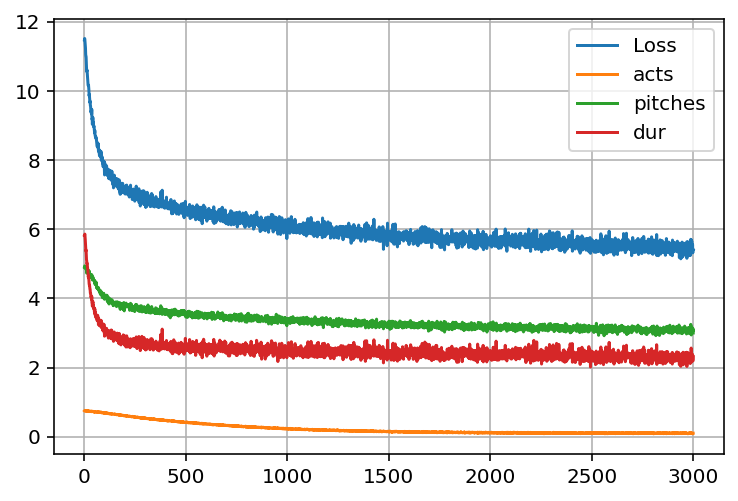

In [37]:
losses = checkpoint['losses']

plt.plot(range(1, len(losses['tot'])+1), losses['tot'], label='Loss')
plt.plot(range(1, len(losses['acts'])+1), losses['acts'], label='acts')
plt.plot(range(1, len(losses['pitches'])+1), losses['pitches'], label='pitches')
plt.plot(range(1, len(losses['dur'])+1), losses['dur'], label='dur')
#plt.plot(range(1, len(losses['kld'])+1), losses['kld'], label='kld')
plt.grid()
plt.legend()

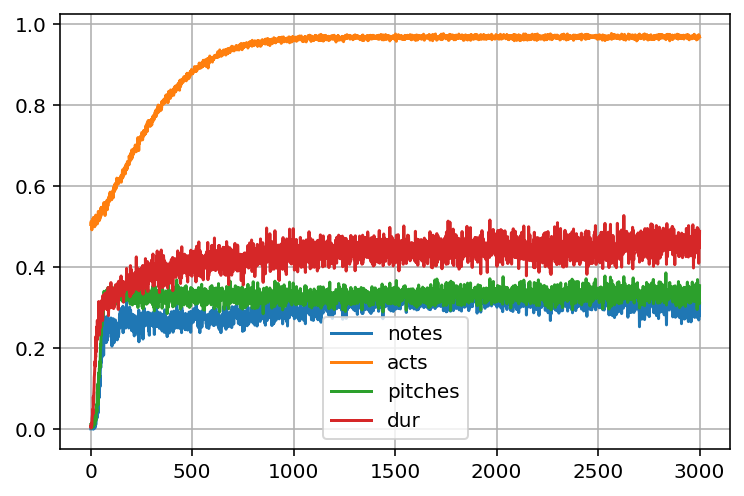

In [32]:
accs = checkpoint['accuracies']
plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.grid()
plt.legend()

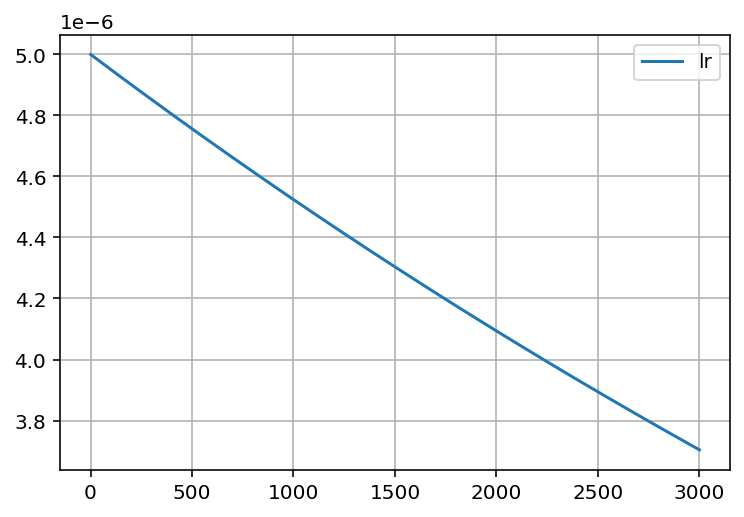

In [33]:
plt.plot(range(1, len(checkpoint['lrs'])+1), checkpoint['lrs'], label='lr')
plt.grid()
plt.legend()

In [34]:
checkpoint['lrs'][-1]

3.7040355387545645e-06

Reconstruct

In [ ]:
dataset[0][0].size()
notes = []
notes.append(muspy.Note(1, 48, 20, 64))
drums = muspy.Track(is_drum=True)
bass = muspy.Track(program=34, notes=notes)
guitar = muspy.Track(program=26, notes=notes)
strings = muspy.Track(program=41)

tracks = [drums, bass, guitar, strings]

meta = muspy.Metadata(title='gay')
music = muspy.Music(tracks=tracks, metadata=meta, resolution=32)
muspy.show_pianoroll(music)

# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape